# Analyzing the quality of NEIMS ONSSiMe3 predictions

We want to know wether the NEIMS intensity prediction is any good. 

zadani: mrknout se, jestli poradi podle velikosti na spektru z NISTu a vygenerovanyho NEIMS spektra sedi "aspon polovina z prvnich dvaceti" (ales)

In [ ]:
pip install spectrum-utils

In [21]:
import numpy as np
from matchms.importing import load_from_msp
from matchms.filtering import normalize_intensities

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from rdkit.Chem import PandasTools
from pandas import DataFrame as df
from rdkit import Chem
from rdkit.Chem.inchi import MolToInchiKey

import os
import spectrum_utils.plot as sup
import spectrum_utils.spectrum as sus
from collections import Counter
import random

### Loading the data

#### NEIMS test Smiles to enriched SDF

In [22]:
!pwd

/auto/brno6/home/ahajek/Spektro/MassGenie


In [32]:
def filter_corrupted_smiles(pp):
    for index, row in pp.iterrows():
#         print(row[2])
        try:
            mol = Chem.Mol(row[2])
        except:
            pp.drop(index, inplace=True)
#     print("after filtering corrupted molecules:", len(pp))
    return pp
            
whole_test_path = "data/trial_set/ales_smilesy/NIST_ONSSiMe3.txt"
tmp_smiles_path = "../NEIMS/tmp/tmp_smiles.txt"
sdf_before = "/storage/projects/msml/mg_neims_branch/NEIMS/tmp/ONSSiMe3_tmp_before.sdf"
sdf_after = "/storage/projects/msml/mg_neims_branch/NEIMS/tmp/ONSSiMe3_tmp_after.sdf"
size = 11600 # full = 11600

model_weights = "../NEIMS/NEIMS_weights"
with open(whole_test_path, "r") as test_f, open(tmp_smiles_path, "w") as tmp_smiles:
    np.random.seed(42)
    data = test_f.readlines()
    r_arr = np.random.choice(np.arange(0, len(data)), replace=False, size=len(data))
    r_smiles = np.unique(np.array([data[i] for i in r_arr]))
    r_id_smiles = list(zip(r_arr, r_smiles))    
    smiles_to_w = "".join(["\t".join([str(x),y]) for x,y in r_id_smiles])
    tmp_smiles.write(smiles_to_w)

pp = pd.read_csv(tmp_smiles_path, names=['id', 'smiles'], sep="\t") 
PandasTools.AddMoleculeColumnToFrame(pp, smilesCol='smiles', molCol='ROMol')
pp = pp.assign(inchikey=lambda x: [MolToInchiKey(mol) for mol in x["ROMol"]])#.set_index("ID")
pp = filter_corrupted_smiles(pp)

# filter pp to unique according to inchikey
pp = pp.drop_duplicates(subset=["inchikey"])

PandasTools.WriteSDF(pp, sdf_before, idName="id", properties=list(pp.columns))

print(f"now run in terminal:\n###############\nconda activate NEIMSpy2 && bash /storage/projects/msml/mg_neims_branch/NEIMS/run_make_spectra_prediction.sh {sdf_before} {sdf_after} && conda deactivate\n###############\n")

now run in terminal:
###############
conda activate NEIMSpy2 && bash /storage/projects/msml/mg_neims_branch/NEIMS/run_make_spectra_prediction.sh /storage/projects/msml/mg_neims_branch/NEIMS/tmp/ONSSiMe3_tmp_before.sdf /storage/projects/msml/mg_neims_branch/NEIMS/tmp/ONSSiMe3_tmp_after.sdf && conda deactivate
###############



In [33]:
len(pp)

5916

In [42]:
# neims_test_path = "../NEIMS/testdata/test_14_mend_all_valid.sdf"
neims_test_path = "../NEIMS/tmp/ONSSiMe3_tmp_after.sdf"
nist_path = "./data/20210925_NIST_EI_MS_cleaned.msp"



In [7]:
%%time
nist = [*load_from_msp(nist_path)]

CPU times: user 1min, sys: 2.02 s, total: 1min 2s
Wall time: 1min 2s


In [29]:
nist[33].metadata

{'name': 'Methyl Alcohol',
 'formula': 'CH4O',
 'mw': '32',
 'casno': '67-56-1',
 'id': '34',
 'comment': 'SemiStdNP=354/16/10 StdNP=379/7/34 StdPolar=903/8/35 ; NIST MS# 18836, Seq# R728',
 'inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3',
 'inchikey': 'OKKJLVBELUTLKV-UHFFFAOYSA-N',
 'iupac_name': 'methanol',
 'smiles': 'CO',
 'num peaks': '16'}

In [47]:
neims_test = PandasTools.LoadSDF(neims_test_path, idName="ID", smilesName='Smiles', molColName='Molecule')
# neims_test.rename(index={"ID": "id"})
# neims_test.drop(columns=["Smiles"])
# neims_test

In [48]:
len(neims_test)

5916

In [49]:
%%time
# get NIST ids of molecules in the test set
def get_nist_spec_match(key):
    neims_ids = set(neims_test[key])
#     inchs_hardcode = ['ACDMQGXCXUQPRR-UHFFFAOYSA-N', 'AERCPEPGTLQPIA-UHFFFAOYSA-N', 'AINIUIHENKWQAQ-UHFFFAOYSA-N', 'ALJSKKFUUDIVIZ-UHFFFAOYSA-N', 'AMBLOBPQQDBDBV-UHFFFAOYSA-N', 'AOTDITUXOFRYQJ-UHFFFAOYSA-N', 'APDRRJDWSMBVDP-UHFFFAOYSA-N', 'ARJYSRVARGPUGJ-UHFFFAOYSA-N', 'ARMFNDZUHQNNNQ-UHFFFAOYSA-N', 'AWROPXHQUYAGBK-UHFFFAOYSA-N', 'AXHYVOHTCIQMCS-UHFFFAOYSA-N', 'BABKJGXJWIGPIH-UHFFFAOYSA-N', 'BCCQTHUGNYPNKQ-UHFFFAOYSA-N', 'BCLNYXSBVJBTCO-UHFFFAOYSA-N', 'BHRXDOABTQEHLJ-UHFFFAOYSA-N', 'BJPXDVANDPOYTE-UHFFFAOYSA-N', 'BMQFRVBDTBAQQJ-UHFFFAOYSA-N', 'BQZNDKSRCLMQQF-UHFFFAOYSA-N', 'BXLITIIYITYRJV-UHFFFAOYSA-N', 'CAGDKDNXQZFLSL-UHFFFAOYSA-N', 'CALQXVJPGUTRRJ-UHFFFAOYSA-N', 'CDCIQINXMINSBF-UHFFFAOYSA-N', 'CFKQKONJGUXMBI-UHFFFAOYSA-N', 'CHKDSWDHLQVLSP-UHFFFAOYSA-N', 'CISBSUGRAJLSLW-UHFFFAOYSA-N', 'CJUCWDRCQRKKGS-UHFFFAOYSA-N', 'CKZSFVYLUTZEAC-UHFFFAOYSA-N', 'CLRNKJKTGSVFPC-UHFFFAOYSA-N', 'COBCUGNBPXFJPS-UHFFFAOYSA-N', 'CQENASWQFJJLOA-UHFFFAOYSA-N', 'CSSMYSSMJKBBSE-UHFFFAOYSA-N', 'CWBGORNRWMPNHX-UHFFFAOYSA-N', 'CXBPQUUAZRJVRK-UHFFFAOYSA-N', 'CXRIAGSQFAEHQK-UHFFFAOYSA-N', 'DDNLURYUKFGSRO-UHFFFAOYSA-N', 'DJGZFMGSCOSLED-UHFFFAOYSA-N', 'DRPLREKOUDQTFB-UHFFFAOYSA-N', 'DUWUONQIHVHTIN-UHFFFAOYSA-N', 'DWCKHJNILPFLFM-UHFFFAOYSA-N', 'DZJKOQFIBZROAK-UHFFFAOYSA-N', 'FAHNVBSWLWGBTQ-UHFFFAOYSA-N', 'FFEVUTYFVPQKAH-UHFFFAOYSA-N', 'FHDZAXHGUKDQRK-UHFFFAOYSA-N', 'FJESOKAMHPDCON-UHFFFAOYSA-N', 'FMJAZQJTRKGXJQ-UHFFFAOYSA-N', 'FSXFGYKXGUGKGI-UHFFFAOYSA-N', 'GAGHQBMOXLVOIC-UHFFFAOYSA-N', 'GBDSWPZRIFDLFL-UHFFFAOYSA-N', 'GDHXOSRCMHCXGC-UHFFFAOYSA-N', 'GDRFCGJSGUNOIY-UHFFFAOYSA-N', 'GHLBZCVNTDKTAN-UHFFFAOYSA-N', 'GIUGKXYPAYLRPS-UHFFFAOYSA-N', 'GNBGDFGBGJLMBN-UHFFFAOYSA-N', 'GOCVWPAKUZHOPC-UHFFFAOYSA-N', 'GSRNTHRSZYGUDR-UHFFFAOYSA-N', 'GTOWQESBIOCZGR-UHFFFAOYSA-N', 'GUBRFQGQOMIXKF-UHFFFAOYSA-N', 'GWGXVENDSVQVIT-UHFFFAOYSA-N', 'HAERUSSVAPHWOX-UHFFFAOYSA-N', 'HBJDZKJWOKOIFZ-UHFFFAOYSA-N', 'HDEVSCYGENVKRV-UHFFFAOYSA-N', 'HFKRKFPJFSKBKB-UHFFFAOYSA-N', 'HGUXLJFEHRQBOG-UHFFFAOYSA-N', 'HKPPXYQBUQGSLW-UHFFFAOYSA-N', 'HLKYXJORXHFJDH-UHFFFAOYSA-N', 'HLQSLEYRGAOMMX-UHFFFAOYSA-N', 'HNCXADDJOWNYNR-UHFFFAOYSA-N', 'HOGROCWSGKMQBI-UHFFFAOYSA-N', 'HOQATXYVXGTIRM-UHFFFAOYSA-N', 'HTHDWSKCERCBQW-UHFFFAOYSA-N', 'HTWJARXIEACBPD-UHFFFAOYSA-N', 'HXXNGIAITHCMCC-UHFFFAOYSA-N', 'HZCOFNACDHIZBT-UHFFFAOYSA-N', 'IBUWRFQPAQWUEY-UHFFFAOYSA-N', 'IGPQQOXZERTVOC-UHFFFAOYSA-N', 'IJIKMXCGHQJGKS-UHFFFAOYSA-N', 'IJTOPHBEHVAJEP-UHFFFAOYSA-N', 'IOAZSQWRGGKIQW-UHFFFAOYSA-N', 'IOEHPHGYBBUPQJ-UHFFFAOYSA-N', 'ITPSSCXAHODMCH-UHFFFAOYSA-N', 'IYZOTNMSELCNTN-UHFFFAOYSA-N', 'JALQSBKJXHFAJP-UHFFFAOYSA-N', 'JDDUOQRGYRTILL-UHFFFAOYSA-N', 'JDIQPNCDHBDSEF-UHFFFAOYSA-N', 'JFGVSIOXNANHFX-UHFFFAOYSA-N', 'JGYAMBPOIKUTNX-UHFFFAOYSA-N', 'JINQONQOMNFERO-UHFFFAOYSA-N', 'JPQCMVPHHGAOET-UHFFFAOYSA-N', 'JQDRAVIXOQTDJT-UHFFFAOYSA-N', 'JVRLEPOAWXRMAL-UHFFFAOYSA-N', 'KCJJBWAKOLQZPD-UHFFFAOYSA-N', 'KGKKKEGGFPCHOP-UHFFFAOYSA-N', 'KIABHBFUCCKJMM-UHFFFAOYSA-N', 'KJBREHYVQGFTTO-UHFFFAOYSA-N', 'KNAZTEWBFRPMHZ-UHFFFAOYSA-N', 'KQDDRTFQDCNQHU-UHFFFAOYSA-N', 'KQFNYHKWWLDVGF-UHFFFAOYSA-N', 'KTHJRONFNUROCL-UHFFFAOYSA-N', 'KYGZQOPCJSIWTN-UHFFFAOYSA-N', 'LCUQQUDLAMRPSH-UHFFFAOYSA-N', 'LDZCLKHVNPFPMQ-UHFFFAOYSA-N', 'LEDLOBXETAOOPL-UHFFFAOYSA-N', 'LFMLHOXMEIEAPQ-UHFFFAOYSA-N', 'LGCNBHVXXPUSDL-UHFFFAOYSA-N', 'LJUJGSMOZDPIJU-UHFFFAOYSA-N', 'LKLDMDACGVZXAN-UHFFFAOYSA-N', 'LKTLQBOOMSFYDT-UHFFFAOYSA-N', 'LLVFXXKDPAPSCJ-UHFFFAOYSA-N', 'LLVFXXKDPAPSCJ-XWIKXRDFSA-N', 'LPZHTUUTYKWYFJ-UHFFFAOYSA-N', 'LTUTXXUPIPZWMI-UHFFFAOYSA-N', 'LYABCSCCIYBZCF-UHFFFAOYSA-N', 'MAYJZCRZAUXNPP-UHFFFAOYSA-N', 'MCEXUMNIMDILTP-UHFFFAOYSA-N', 'MEUDKQMMZWTSLO-UHFFFAOYSA-N', 'MFOIVZWKNBPHHX-UHFFFAOYSA-N', 'MHLAOYWBKGDKTK-UHFFFAOYSA-N', 'MLKCPPZOLRUAOT-UHFFFAOYSA-N', 'MOBSUIKFQIWSJI-UHFFFAOYSA-N', 'MRJCSXFCSPYKSK-UHFFFAOYSA-N', 'MUPBZKSHPSGNPV-UHFFFAOYSA-N', 'MXVIHKQILZIPME-UHFFFAOYSA-N', 'MYBLOPHVHGPKMY-UHFFFAOYSA-N', 'MZVDWEVOVDFJCG-UHFFFAOYSA-N', 'NCTAWABCKGMOME-UHFFFAOYSA-N', 'NGDAQAOYMMIHHW-UHFFFAOYSA-N', 'NHOCVIPQCJEEFR-UHFFFAOYSA-N', 'NHTUKGGVQKRAQX-UHFFFAOYSA-N', 'NKKBOERHOPNLLT-UHFFFAOYSA-N', 'NMNIJHMUFNCRFU-UHFFFAOYSA-N', 'NQWZYCOPCGETLB-UHFFFAOYSA-N', 'NTNNEHYTMNCIOG-UHFFFAOYSA-N', 'NWJDPWPNDHEKBF-UHFFFAOYSA-N', 'NXHPBAOOQCHWHS-UHFFFAOYSA-N', 'NYKPCVVFAUFKOP-UHFFFAOYSA-N', 'NZTMANUPEIWDMS-UHFFFAOYSA-N', 'OEPFPGAZIPKWDG-UHFFFAOYSA-N', 'OIUIKIGMQBHOGR-UHFFFAOYSA-N', 'OJFDKIYZEFLERA-UHFFFAOYSA-N', 'OKWPSPPSKQXZNS-UHFFFAOYSA-N', 'OKXOCFCOPKTLSV-UHFFFAOYSA-N', 'ONGAISBRKJEXIT-UHFFFAOYSA-N', 'OQODXBKTVOKPMR-UHFFFAOYSA-N', 'OSGBHAQVXKQWEL-UHFFFAOYSA-N', 'OTEUNJFANYWFIN-UHFFFAOYSA-N', 'OTSVOXJGQUBGDM-UHFFFAOYSA-N', 'OWRQZYHPMBQGDO-UHFFFAOYSA-N', 'PBPMVVKNXRNOCL-UHFFFAOYSA-N', 'PCWCATLIOGCOLF-UHFFFAOYSA-N', 'PJPDVLGYQXLVBN-UHFFFAOYSA-N', 'PRZGIUIKCGRVGY-UHFFFAOYSA-N', 'PSADISLEXXYAFO-UHFFFAOYSA-N', 'PTATVCBELMZANG-UHFFFAOYSA-N', 'PXOKPPIJGPHDHH-UHFFFAOYSA-N', 'PYHVQDNQPUVBIE-UHFFFAOYSA-N', 'PYLXLHQAZZMFRY-UHFFFAOYSA-N', 'PYVWRESWXOBNBW-UHFFFAOYSA-N', 'PZGWMAIUYJWGSH-UHFFFAOYSA-N', 'QAMJELYAADDYTN-UHFFFAOYSA-N', 'QBWVJRPYCBSYJJ-UHFFFAOYSA-N', 'QDEFZWVWFGZSRJ-UHFFFAOYSA-N', 'QEXSXDOPYCQXGF-UHFFFAOYSA-N', 'QLGCNHXGJIUDLW-UHFFFAOYSA-N', 'QLZYEYVOOHYNHB-UHFFFAOYSA-N', 'QQESWKBZGHNCSQ-UHFFFAOYSA-N', 'QRZHLXDYKDCOPI-UHFFFAOYSA-N', 'QUEWWGOFCLVAQD-UHFFFAOYSA-N', 'QVYCPZLTVOPAPC-UHFFFAOYSA-N', 'QYHOYGSPGJVBNL-UHFFFAOYSA-N', 'QYVPPKLFPCFKFT-UHFFFAOYSA-N', 'QZUJNZWYYAUSBD-UHFFFAOYSA-N', 'RAEAUBWHKVENMH-UHFFFAOYSA-N', 'RANCDCDXOPOGJE-UHFFFAOYSA-N', 'RDATZQIINHXKAG-UHFFFAOYSA-N', 'RFIHJHALONOSJC-UHFFFAOYSA-N', 'RJQVFVQPIYXEJP-UHFFFAOYSA-N', 'RRSOGLILPGTBIZ-UHFFFAOYSA-N', 'RTBBMHHUSLGXCC-UHFFFAOYSA-N', 'RUELDULSVBQTPH-UHFFFAOYSA-N', 'RUEPETJRIPUBSY-UHFFFAOYSA-N', 'RUXWNNBBHWDDKB-UHFFFAOYSA-N', 'RWPUIXJBMPBOCU-UHFFFAOYSA-N', 'RYMAGTBAIGYTKX-UHFFFAOYSA-N', 'SEYVZGBPBXCQMT-UHFFFAOYSA-N', 'SFXUCUOVEDBETC-UHFFFAOYSA-N', 'SIQATVKXZKXVDA-UHFFFAOYSA-N', 'SJKLCCAXCVVSIK-UHFFFAOYSA-N', 'SMBGLBTVRXTELZ-UHFFFAOYSA-N', 'SROWHFXQCGCWEL-UHFFFAOYSA-N', 'SUHMVFNFUHAXFJ-UHFFFAOYSA-N', 'SXUVIFIZLGMRBJ-UHFFFAOYSA-N', 'SZAYOPLRPNKHAR-UHFFFAOYSA-N', 'TZXJBRONCJNUGM-UHFFFAOYSA-N', 'UEDLYTHDQROCNM-UHFFFAOYSA-N', 'UEUVXEVIVZCSKS-UHFFFAOYSA-N', 'UJRFOJLCOGKWOK-UHFFFAOYSA-N', 'UKHOOQDPQPXMJI-UHFFFAOYSA-N', 'UNXSIEHQTMNMMY-UHFFFAOYSA-N', 'USNOZWSDHCTQFH-UHFFFAOYSA-N', 'UYVDDMRRJHRESQ-UHFFFAOYSA-N', 'VCRLPWHRJGMTAG-UHFFFAOYSA-N', 'VCRZSKFYFGBURI-UHFFFAOYSA-N', 'VFUIXYOCOKKNQM-UHFFFAOYSA-N', 'VHBCBQDDKWHIRE-UHFFFAOYSA-N', 'VJEOMMARRWTVGD-UHFFFAOYSA-N', 'VMQXABSWVDPWSF-UHFFFAOYSA-N', 'VQHJQZLZZGBELK-UHFFFAOYSA-N', 'VQKWGPZGEROFQY-UHFFFAOYSA-N', 'VQPHJUFIZVDKSU-UHFFFAOYSA-N', 'VTFDBWYIMCQFRV-UHFFFAOYSA-N', 'VXQDFDJIOKROSU-UHFFFAOYSA-N', 'WARJNGNOEBGXKS-UHFFFAOYSA-N', 'WBIXLVJASZDBTI-UHFFFAOYSA-N', 'WBUUEQUAMHQROV-UHFFFAOYSA-N', 'WBZUICVEOOQMOT-UHFFFAOYSA-N', 'WJNPTFCNXUIRIH-UHFFFAOYSA-N', 'WPPGDMRLWMCELS-UHFFFAOYSA-N', 'WTKRVTNJHQUGHW-UHFFFAOYSA-N', 'WYTZPEKRKZEVDR-UHFFFAOYSA-N', 'WZZDCZPDFSSOIG-UHFFFAOYSA-N', 'XCNGMXKDGCALRD-UHFFFAOYSA-N', 'XFTDTOSLXSCVFT-UHFFFAOYSA-N', 'XJOGKXHVOUKKQX-UHFFFAOYSA-N', 'XKLJIDRRSIIYPO-UHFFFAOYSA-N', 'XLFNXSBVOXZKBM-UHFFFAOYSA-N', 'XLVHRCJHXKBWCP-UHFFFAOYSA-N', 'XMYSHIBIHGMCSP-UHFFFAOYSA-N', 'XOJWDKCJPHNNOH-UHFFFAOYSA-N', 'XPDALQOLOZEWHW-UHFFFAOYSA-N', 'XPFYJPCRPJTVKR-UHFFFAOYSA-N', 'XTBHNEOYCOFRFN-UHFFFAOYSA-N', 'XXLBVMAPXXBJCG-UHFFFAOYSA-N', 'XZBCBPCBEMDPQI-UHFFFAOYSA-N', 'YBQIXFAIJNZVRV-UHFFFAOYSA-N', 'YJBYWXGITBYJQL-UHFFFAOYSA-N', 'YLVHVMDZXDBGOJ-UHFFFAOYSA-N', 'YNSWALLUTMDIJI-UHFFFAOYSA-N', 'YVRGZISAUYSGJK-UHFFFAOYSA-N', 'YWUNCOFVVOBGJA-UHFFFAOYSA-N', 'YYSWWEZTMCCHGH-UHFFFAOYSA-N', 'ZBEJHGUYYNELJI-UHFFFAOYSA-N', 'ZDGFYSBILJZZFV-UHFFFAOYSA-N', 'ZDSXOMLVLPGWHE-UHFFFAOYSA-N', 'ZDSXOMLVLPGWHE-WDYDDUQISA-N', 'ZGIAYJFKKBOSOT-UHFFFAOYSA-N', 'ZGUGYUAUEGQMTR-UHFFFAOYSA-N', 'ZKXXOXJXWZDVKZ-UHFFFAOYSA-N', 'ZOGHBJWRMWTXNP-UHFFFAOYSA-N', 'ZQXSMDBFWZHOKW-UHFFFAOYSA-N', 'ZRWZFOKAXVXZIS-UHFFFAOYSA-N', 'ZTZGORUGVYGHSD-UHFFFAOYSA-N', 'ZUCRMUCINLDBSB-UHFFFAOYSA-N', 'ZXARAKRTAKOWKR-UHFFFAOYSA-N', 'ZYPUPEAARWTJQW-UHFFFAOYSA-N']
#     sorted(neims_ids) == inchs_hardcode
#     print(neims_ids)
    ids = []
    no_inchi = []
    counter = 0
    counter_all = 0
    for i, x in enumerate(nist):
        try:
#             print( nist[i].metadata[key])

            id_ = nist[i].metadata[key]
            if id_ in neims_ids:            
#                 nist[i].metadata["smiles"] # test for smiles presence
                
                counter += 1
                ids.append((i, id_))
                neims_ids.remove(id_)
            counter_all += 1
                
        except:
            no_inchi.append(i)
    print("matched ids: ", counter, "/", counter+len(neims_ids))
    print(f"all checked keys {counter_all}")
    print(f"not having key {len(no_inchi)}")
    return sorted(ids), no_inchi
        
key = "smiles"
ids, no_inchi = get_nist_spec_match(key) 

neims_test.drop(neims_test[~neims_test[key].isin([y for x,y in ids])].index, inplace=True)
len(neims_test)
neims_test = neims_test.assign(nist_idMINUS1=lambda x : [i for inch in x[key] for i,k in ids if inch==k])

matched ids:  5916 / 5916
all checked keys 290124
not having key 60494
CPU times: user 3.25 s, sys: 293 ms, total: 3.54 s
Wall time: 3.54 s


In [50]:
# filter out samples without smiles
def create_nist_data(nist, ids):
    nist_test_spec = {}
    didnt_work = []
    for id_, key in ids:
        try:
            nist_test_spec[id_] = {"name": nist[id_].metadata["name"],  
                               "smiles": nist[id_].metadata["smiles"], 
                               "inchikey": nist[id_].metadata["inchikey"],
                               "mz": nist[id_].peaks.mz.astype(int),
                               "intensity": nist[id_].peaks.intensities/max(nist[id_].peaks.intensities)}
    #         print(nist[id_].metadata["smiles"])
        except:
            print(nist[id_].metadata)
            didnt_work.append(id_)
    return nist_test_spec, didnt_work

nist_test_spec, didnt_work = create_nist_data(nist, ids)

In [51]:
print(f"NIST specs that have smiles and everything: {len(nist_test_spec)}/{len(ids)}")

NIST specs that have smiles and everything: 5916/5916


In [52]:
# nist_test_spec

In [53]:
# create neims dataset
def process_neims_spec(spec, smiles):
    spec = spec.split("\n")
    i = []
    mz = []
    for t in spec:
        j,d = t.split()
        mz.append(j)
        i.append(d)
    return {"smiles": smiles, "mz": np.array(mz).astype(int), "intensity": np.array(i).astype(float)/max(np.array(i).astype(float))}

neims_test_spec = {}
for i, ps in neims_test.sort_values(by=['nist_idMINUS1'])[["nist_idMINUS1", "PREDICTED SPECTRUM", "smiles"]].iterrows():
    neims_test_spec[int(ps["nist_idMINUS1"])] = process_neims_spec(ps["PREDICTED SPECTRUM"], ps["smiles"])
#     print(psneims_test_spec[ps["ID"]] = ["PREDICTED SPECTRUM"])
#     print("--")
# neims_test_spec

In [70]:
print(neims_test_spec.keys() == nist_test_spec.keys())
print(len(nist_test_spec.keys()))
print(len(neims_test_spec.keys()))

True
5916
5916


## Spectra visualization

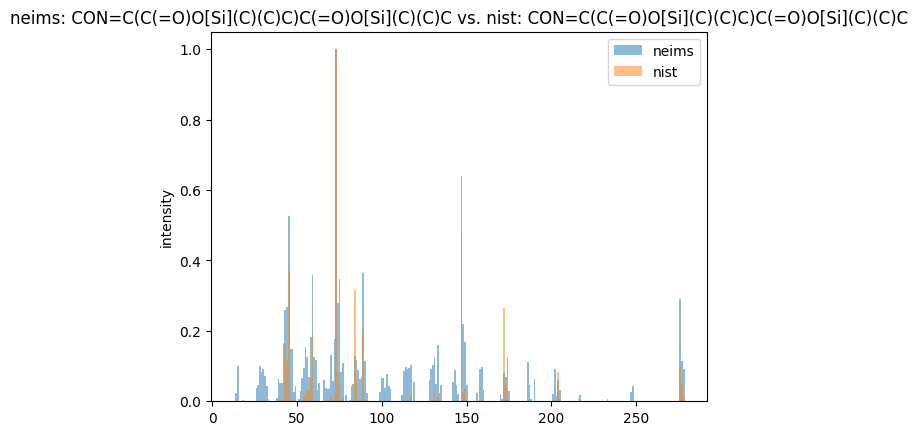

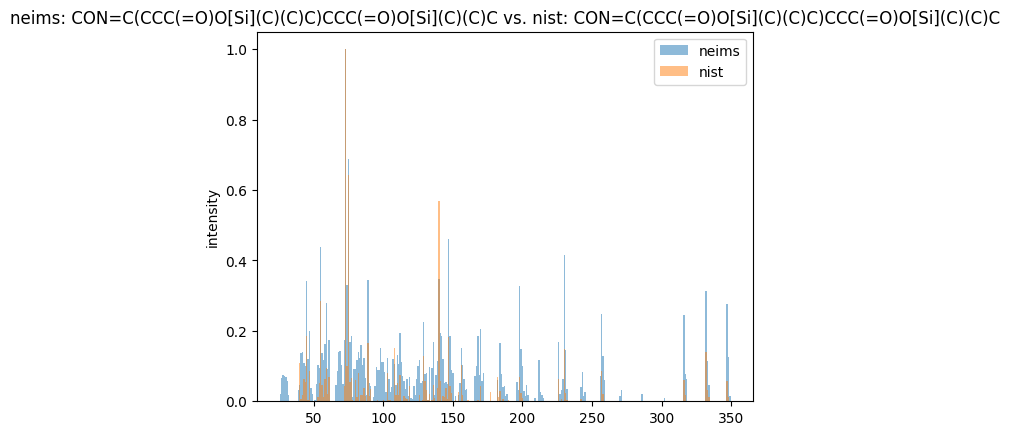

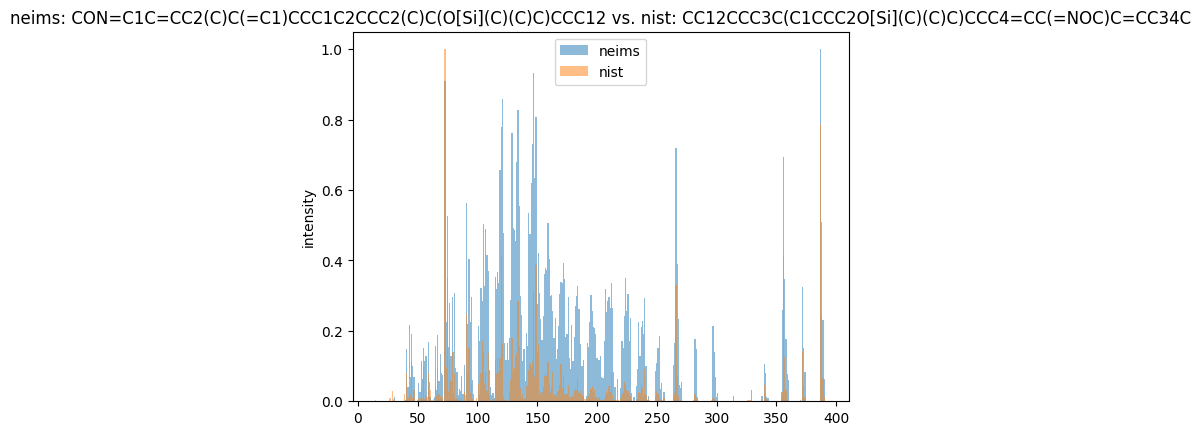

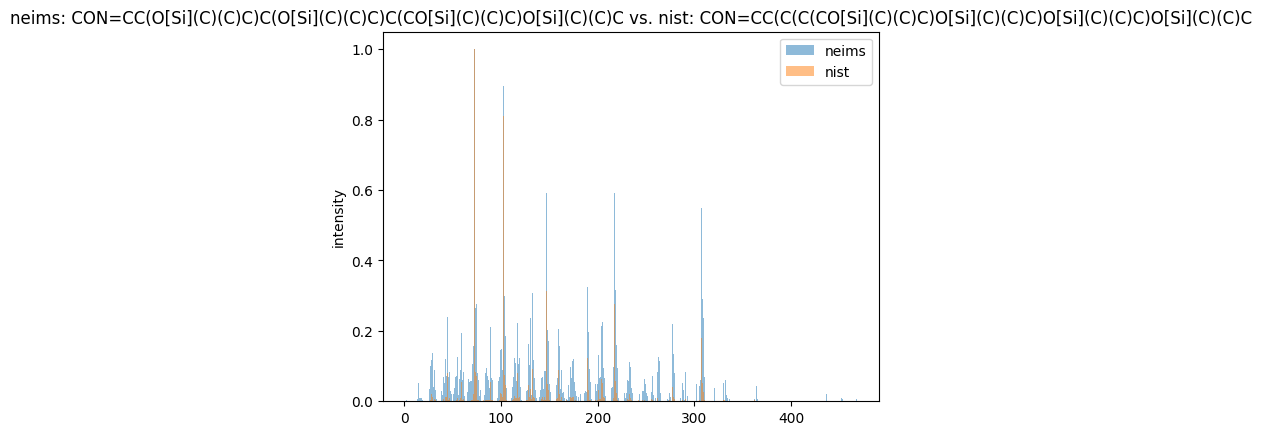

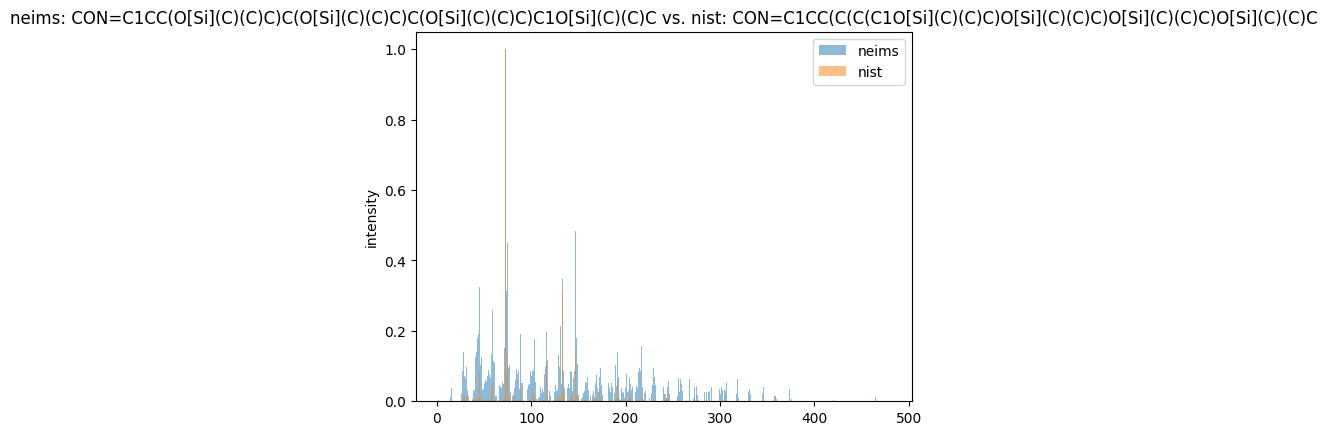

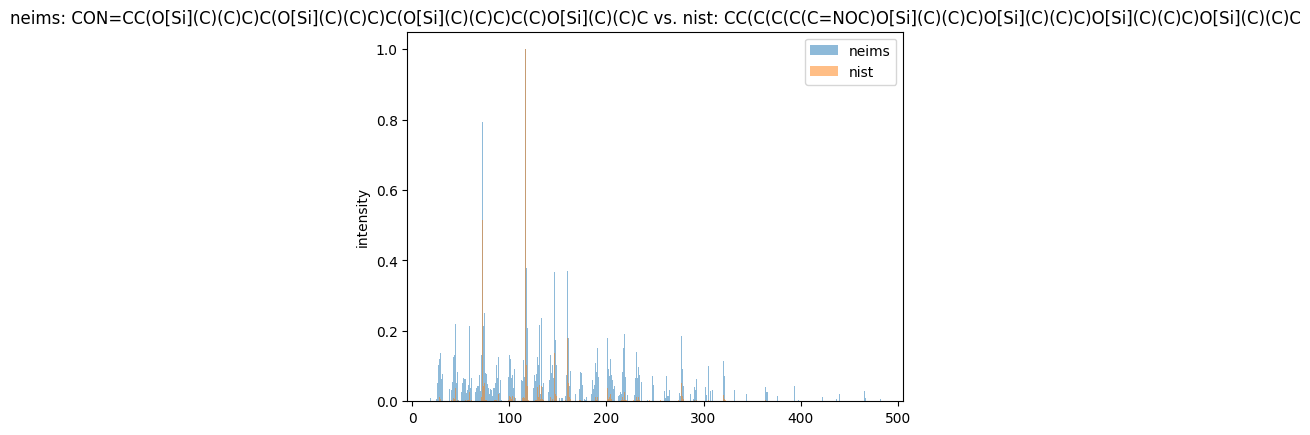

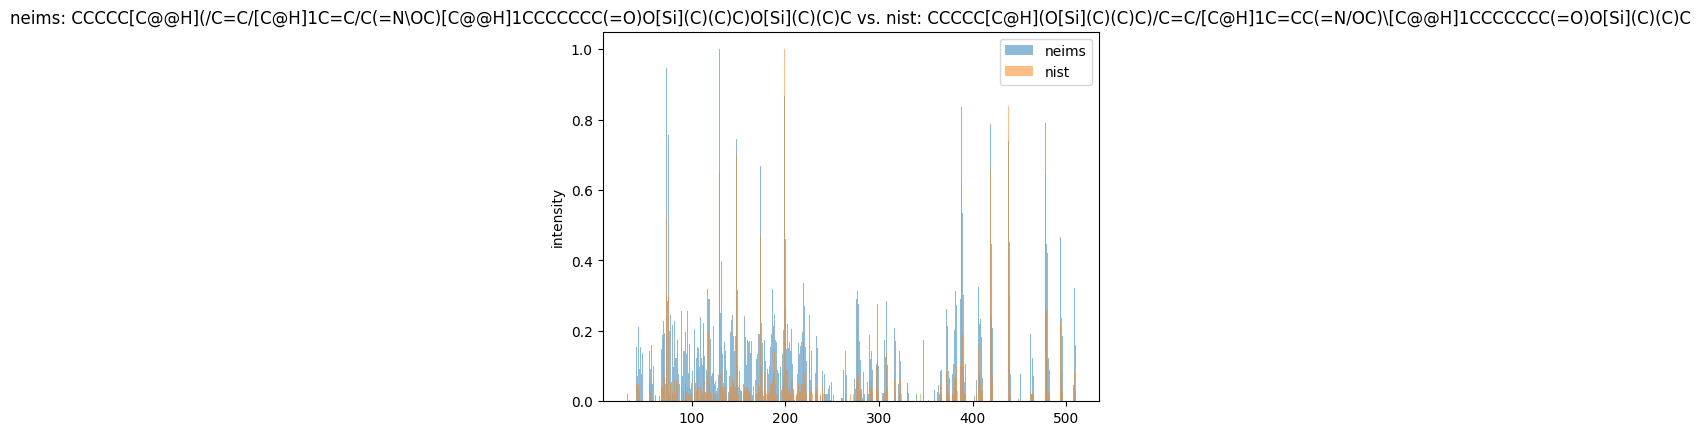

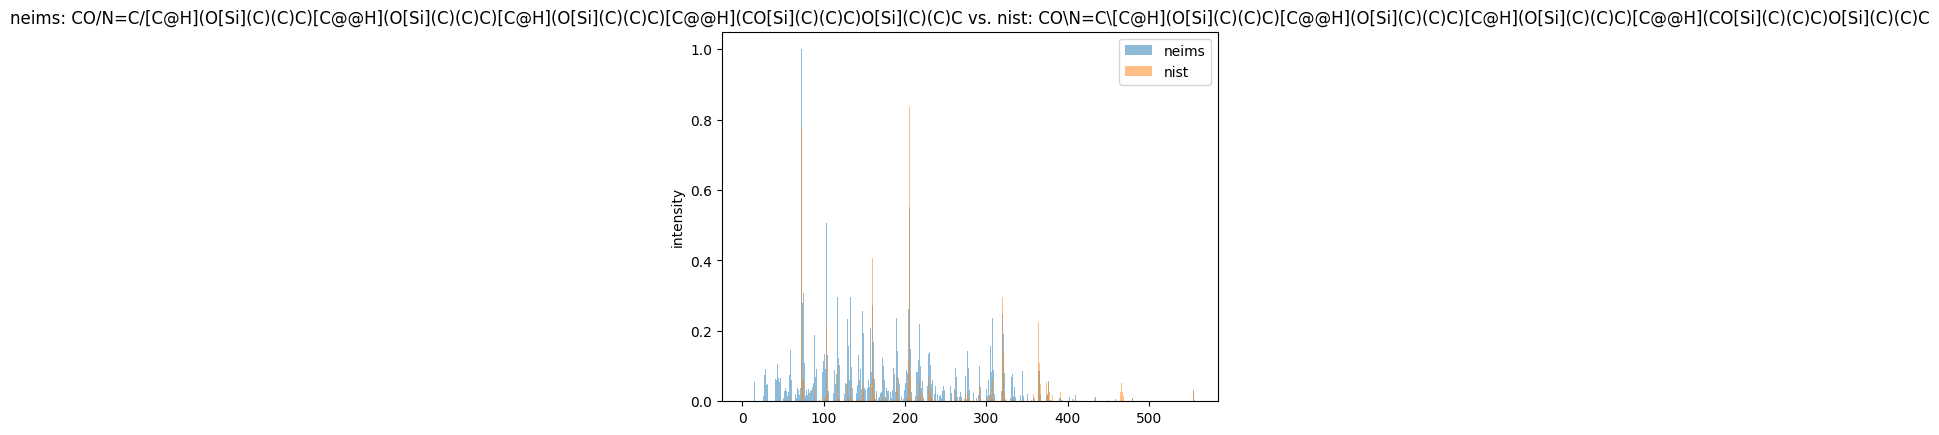

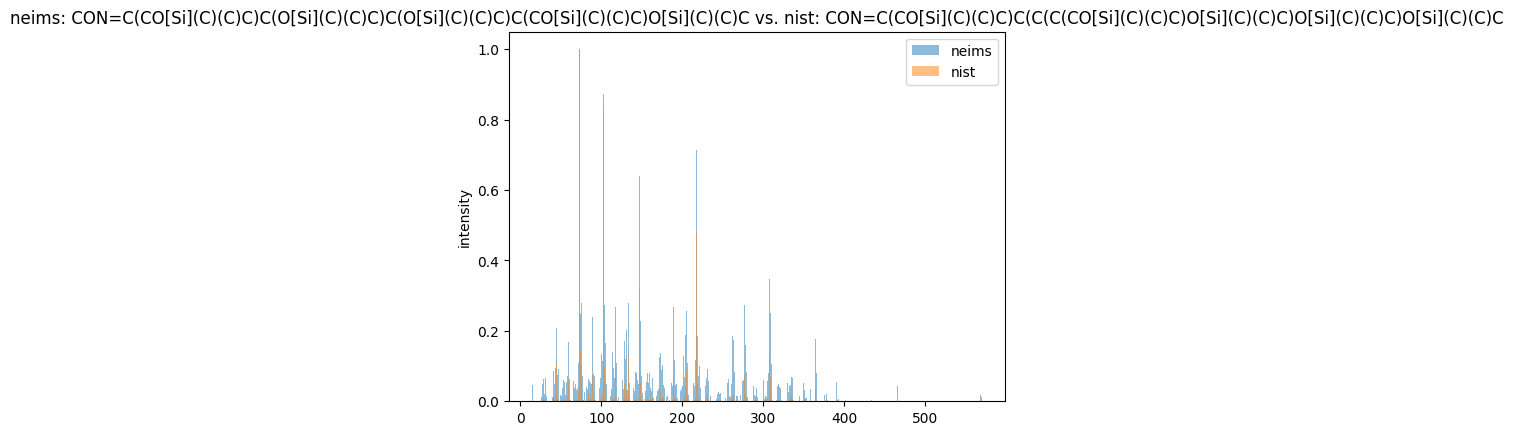

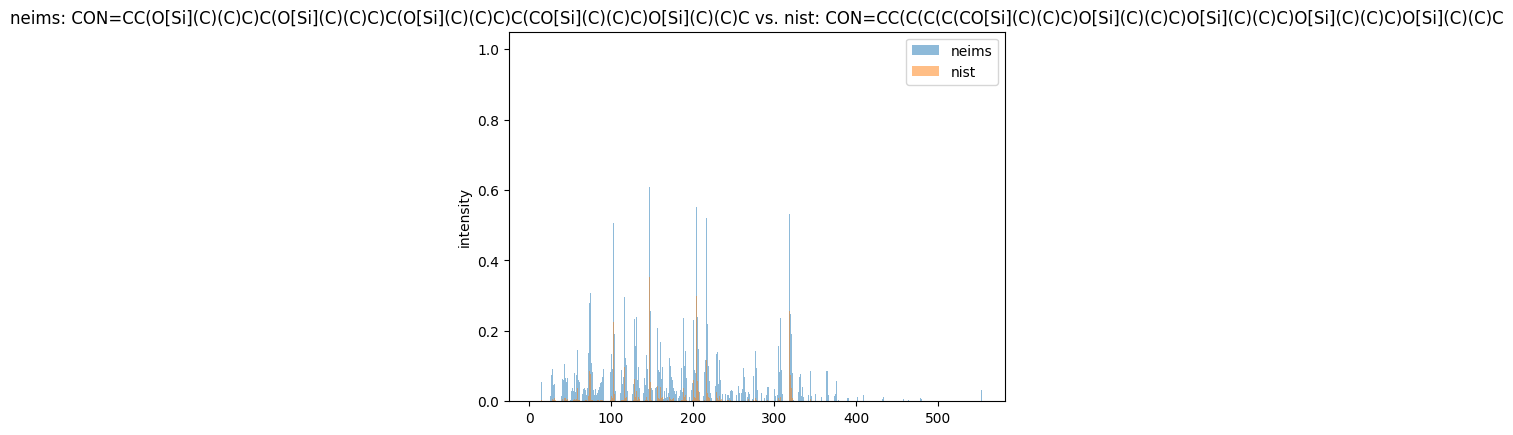

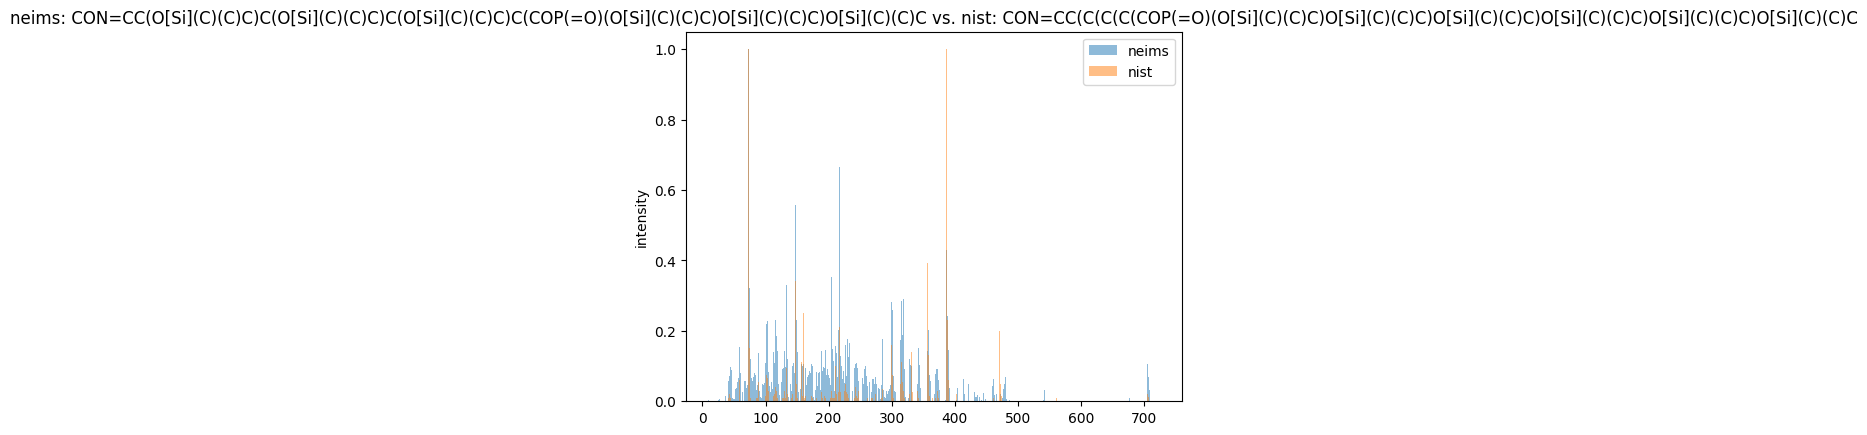

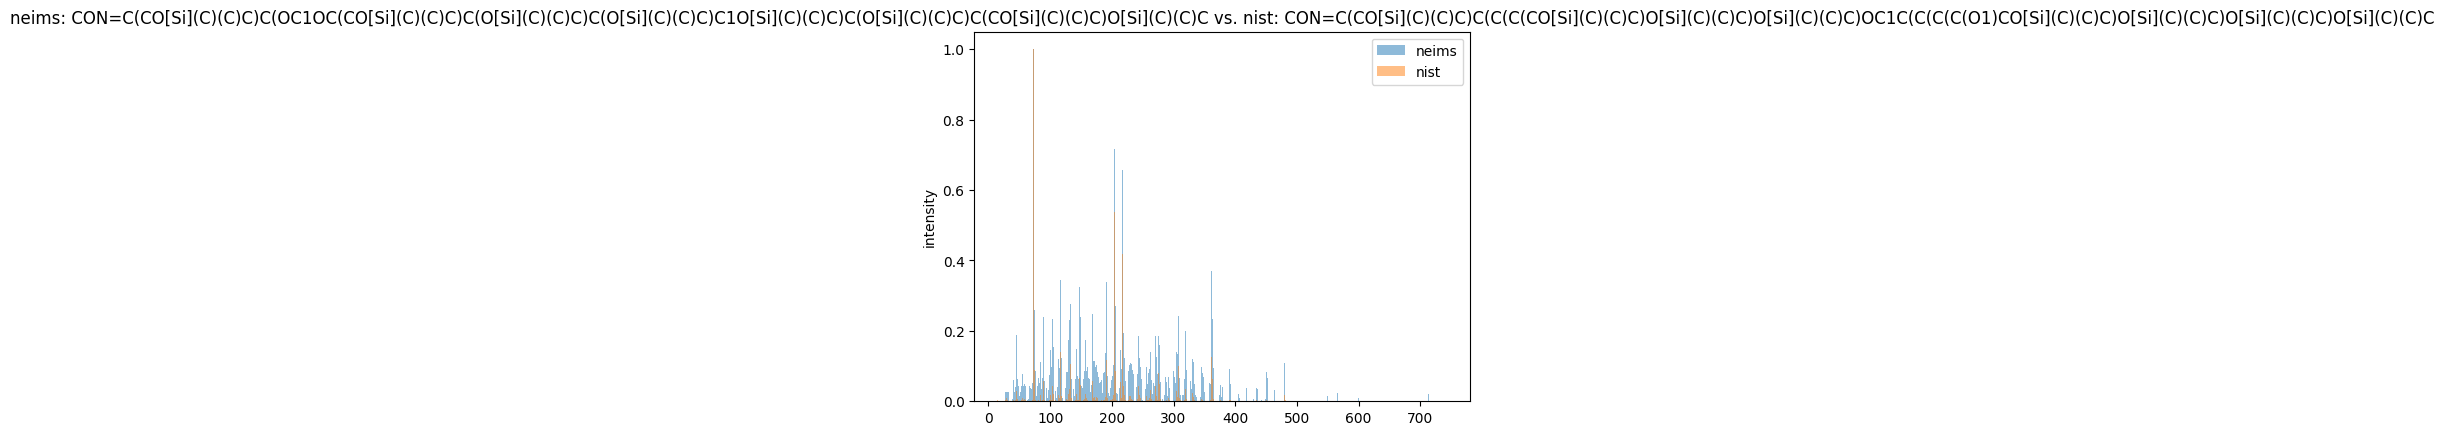

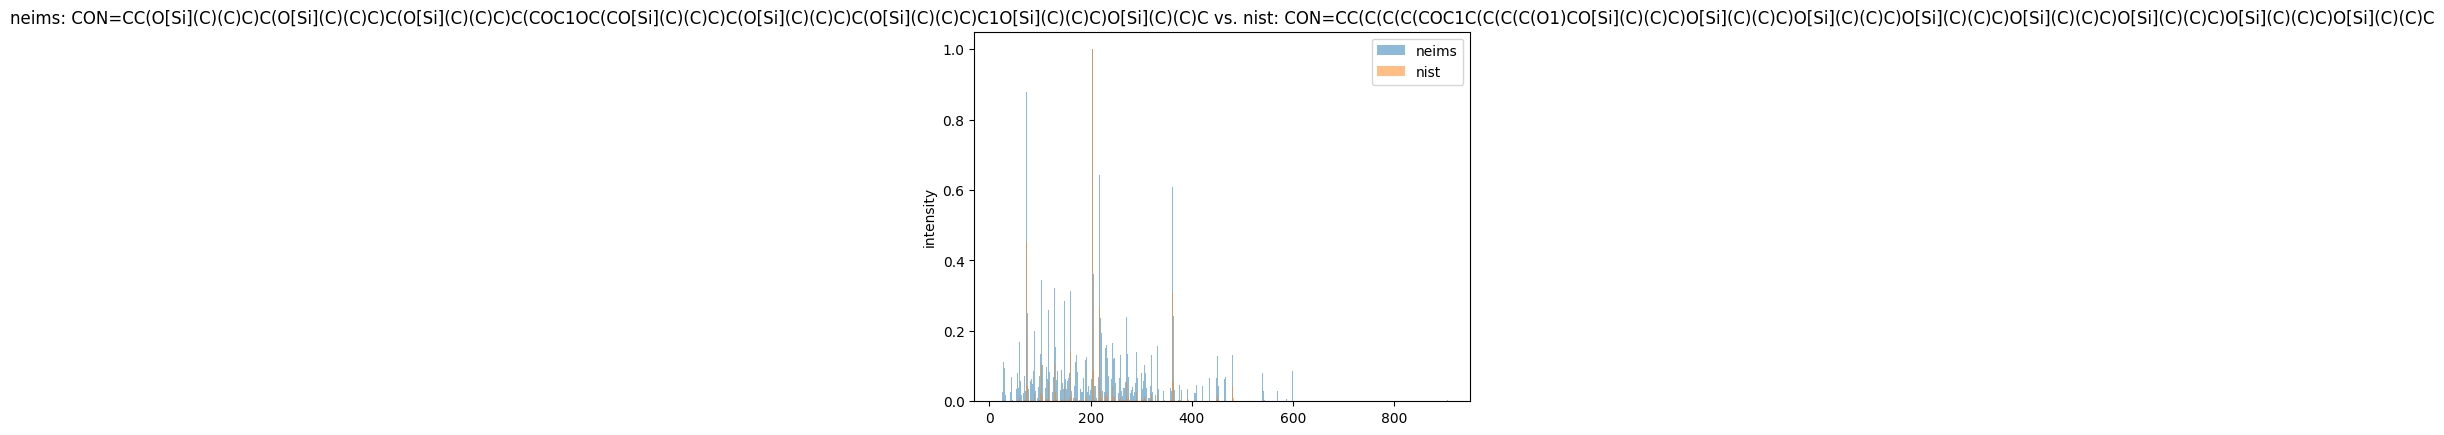

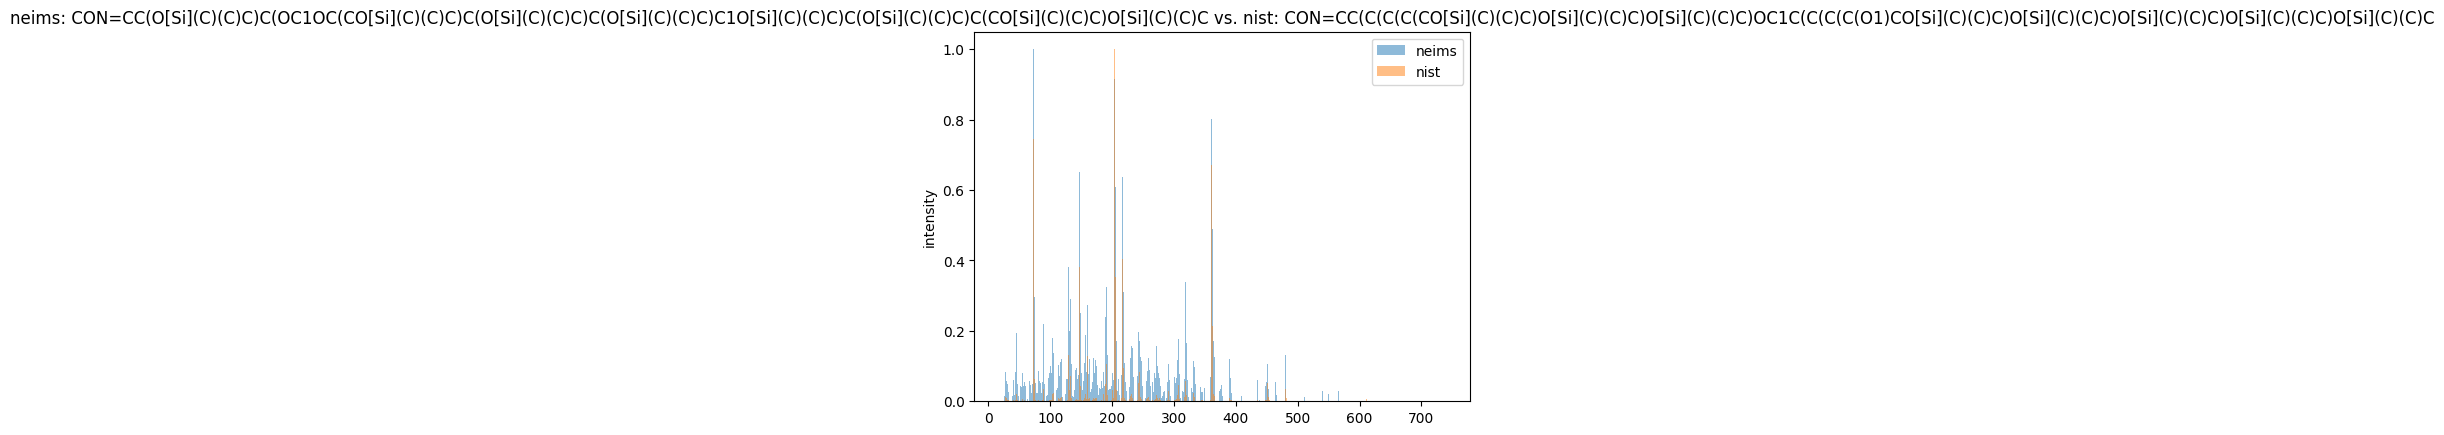

In [95]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

def visualize_two_spectra(neims_spec, nist_spec):
    fig, ax = plt.subplots()
    ax.bar(neims_spec["mz"], height=neims_spec["intensity"], width=1, align='center', alpha=0.5, label="neims") #blue
    ax.bar(nist_spec["mz"], height=nist_spec["intensity"], width=1, align='center', alpha=0.5, label="nist") #orange
    # ax.xticks(y_pos, objects)
    ax.set_ylabel('intensity')
    ax.set_title(f'neims: {neims_spec["smiles"]} vs. nist: {nist_spec["smiles"]}')
    ax.legend()
    plt.show()

def visualize_two_spectra_1array(neims_arr, nist_arr):
    fig, ax = plt.subplots()
    ax.bar(range(len(neims_arr)), height=neims_arr, width=1, align='center', alpha=0.5, label="neims") #blue
    ax.bar(range(len(nist_arr)), height=nist_arr, width=1, align='center', alpha=0.5, label="nist") #orange
    # ax.xticks(y_pos, objects)
    ax.set_ylabel('intensity')
    ax.legend(["NEIMS", "NIST"])
#     ax.set_title(f'neims: {neims_spec["smiles"]} vs. nist: {nist_spec["smiles"]}')
    plt.show()
    
    
for i in neims_test_spec.keys():
    visualize_two_spectra(neims_test_spec[i], nist_test_spec[i])

## Compare the spectra

In [96]:
def visualize_two_bars_per_spec(neims_arr, nist_arr, x_labels, title=None):
    x = np.arange(len(x_labels))  # the label locations
    width = 0.45 # the width of the bars

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 5.5)
    rects1 = ax.bar(x - width/2, neims_arr, width, label='neims')
    rects2 = ax.bar(x + width/2, nist_arr, width, label='nist')

    # Add some text for labels, title and custom x-axis tick labels, etc.
#     ax.set_ylabel('Num of peaks')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
            
    autolabel(rects1)
    autolabel(rects2)
    fig.tight_layout()
    plt.show()

### Visualize lengths of the spectra 

In [98]:
labels = list(neims_test_spec.keys())

In [99]:
neims_lens = np.array([len(neims_test_spec[key]["mz"]) for key in neims_test_spec.keys()])

In [100]:
nist_lens = np.array([len(nist_test_spec[key]["mz"]) for key in nist_test_spec.keys()])

In [101]:
max(neims_lens)

356

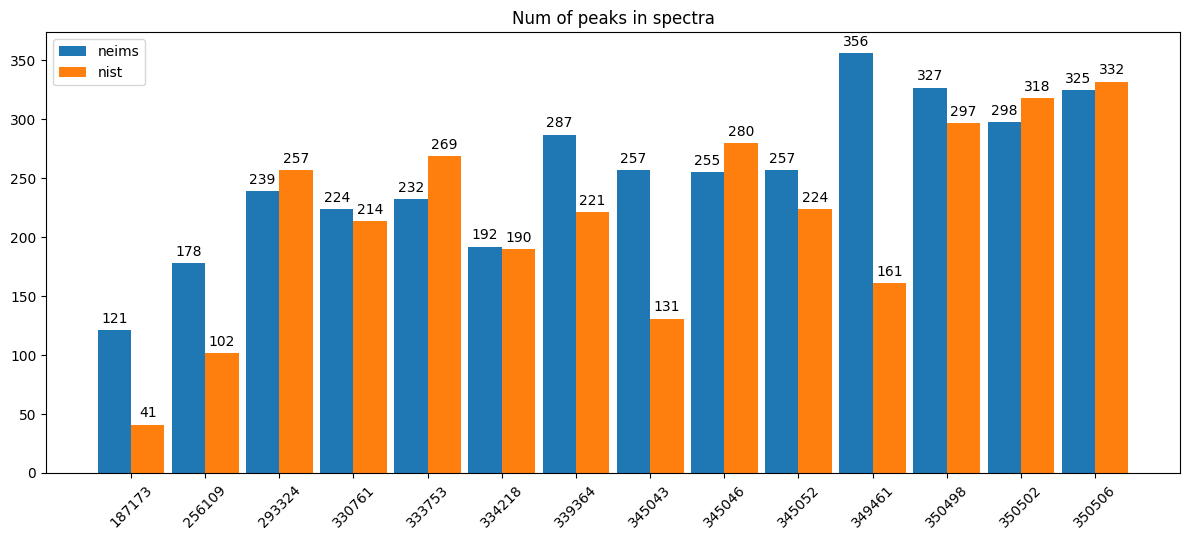

In [102]:
visualize_two_bars_per_spec(neims_lens, nist_lens, labels, title="Num of peaks in spectra")

In [103]:
# the things above this are one cell

In [104]:
# spectra with more than n peaks
n = 150
print(f"NIST spectra with more than {n} peaks:  ", sum(nist_lens > n))
print(f"NEIMS spectra with more than {n} peaks: ", sum(neims_lens > n))

sum(np.any([neims_lens > n, nist_lens > n], axis=0))

NIST spectra with more than 150 peaks:   11
NEIMS spectra with more than 150 peaks:  13


13

In [105]:
nist_over100 = [x for x in neims_lens if x > 100]
neims_over100 = [x for x in nist_lens if x > 100]
print(f"Num of spectra with more than 100 peaks in NIST: {len(nist_over100)}\nrate: {len(nist_over100)/len(nist_lens)}")
print(f"Num of spectra with more than 100 peaks in NEIMS: {len(neims_over100)}\nrate: {len(neims_over100)/len(neims_lens)}")

Num of spectra with more than 100 peaks in NIST: 14
rate: 1.0
Num of spectra with more than 100 peaks in NEIMS: 13
rate: 0.9285714285714286


### Visualize peak sums of the spectra 

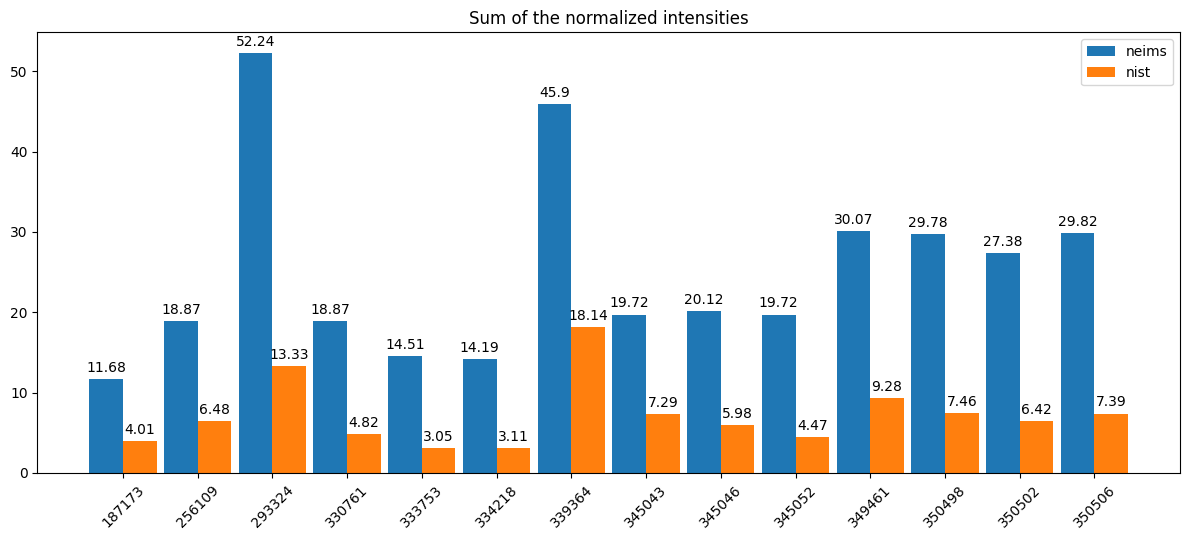

In [106]:
labels = list(neims_test_spec.keys())
neims_lens = [round(sum(neims_test_spec[key]["intensity"]), 2) for key in neims_test_spec.keys()]
nist_lens = [round(sum(nist_test_spec[key]["intensity"]), 2) for key in nist_test_spec.keys()]

visualize_two_bars_per_spec(neims_lens, nist_lens, labels, title="Sum of the normalized intensities")

## Compare NIST's and NEIMS's mzs sorted by intensity

QUESTION: How many of the first n biggest peaks correspond/overlap

In [107]:
# check wether there are duplicities in the intensities (print according ids)
# only to see, the intens. are quite long ints
# for key in neims_test_spec.keys():
#     counter = Counter(neims_test_spec[key]["intensity"])
#     if len(counter.values()) != sum(counter.values()):

In [55]:
# create nist and neims spectra that do not have mz, only 0 on positions that have zero
def put_spectra_to_one_array(data):
    for id_, spec in data.items():
#         print(spec)
        mzs = spec["mz"]
        ints = spec["intensity"]
        max_ = mzs.max()
        new_spec = np.zeros(max_+1)
        for i in range(len(mzs)):
            new_spec[mzs[i]] = ints[i]
        data[id_]["spectrum"] = new_spec
    return data

# toto by se mozna hodilo dat vys rovnou -_o_-
neims_test_spec = put_spectra_to_one_array(neims_test_spec)
nist_test_spec = put_spectra_to_one_array(nist_test_spec)        

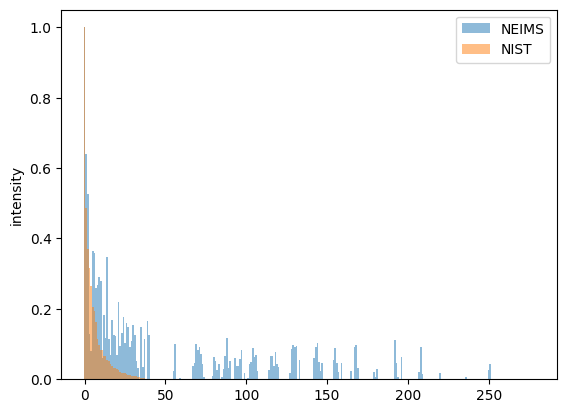

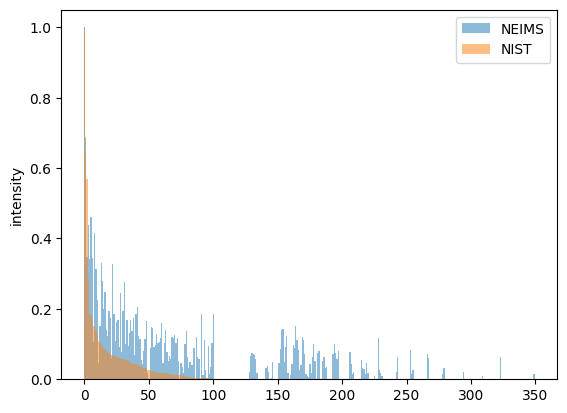

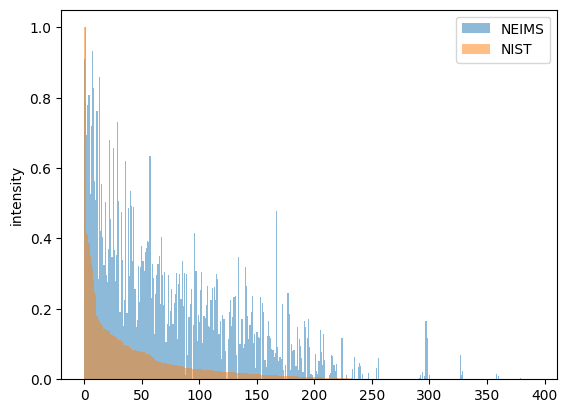

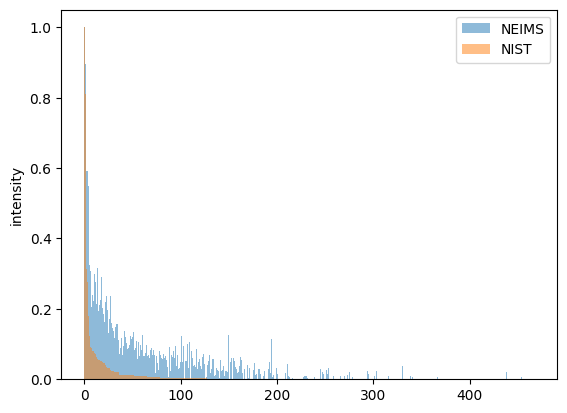

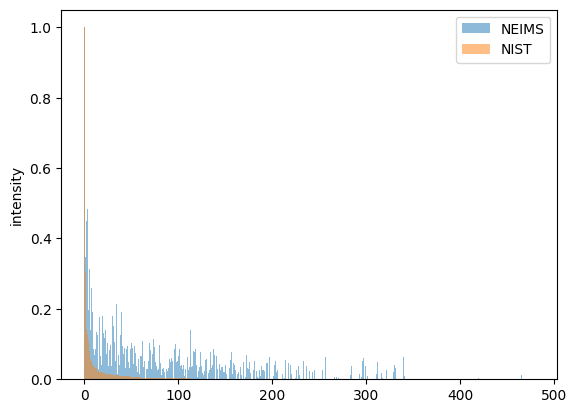

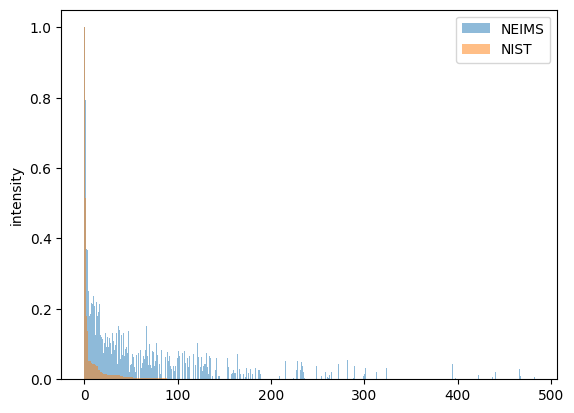

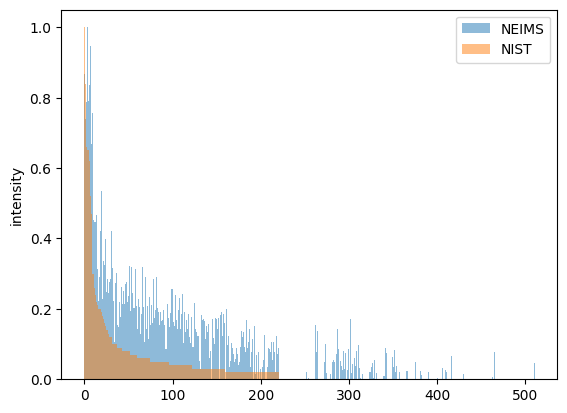

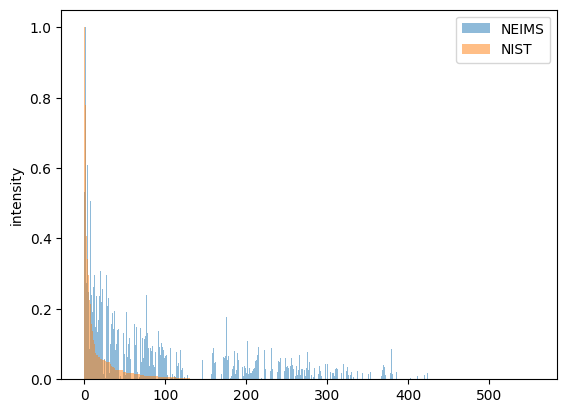

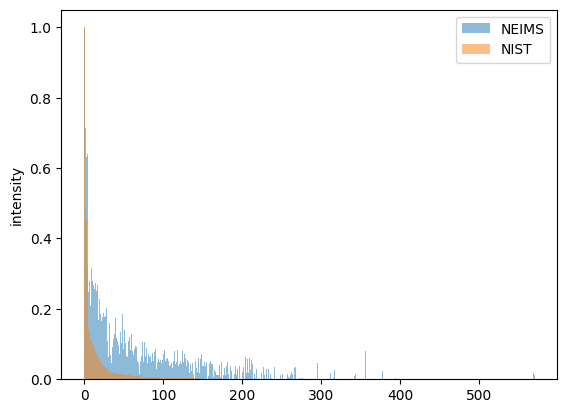

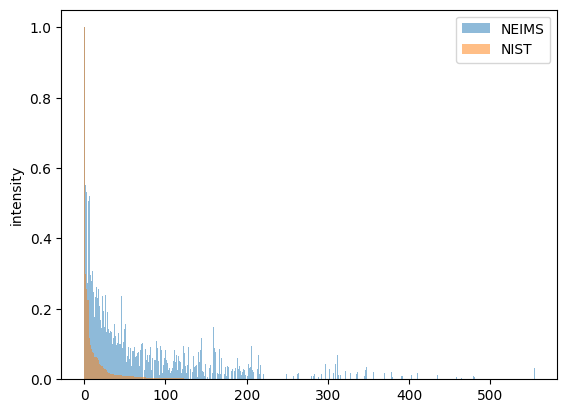

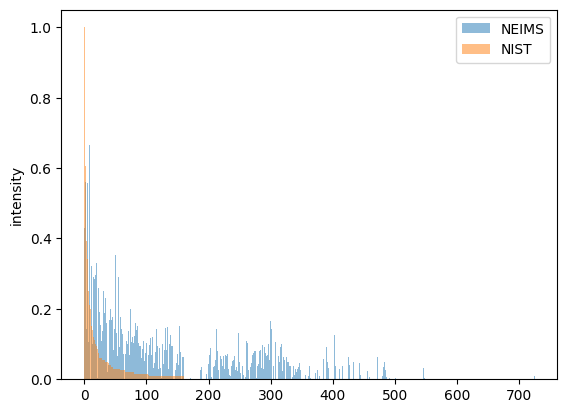

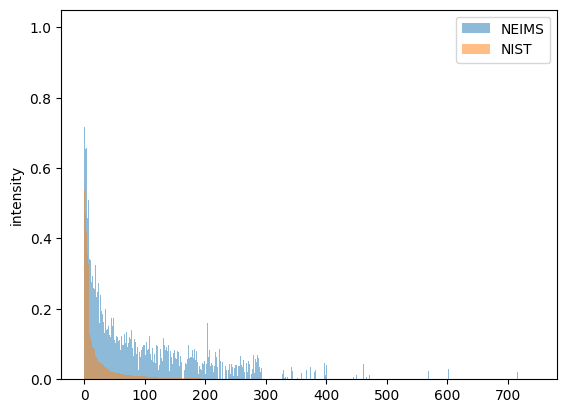

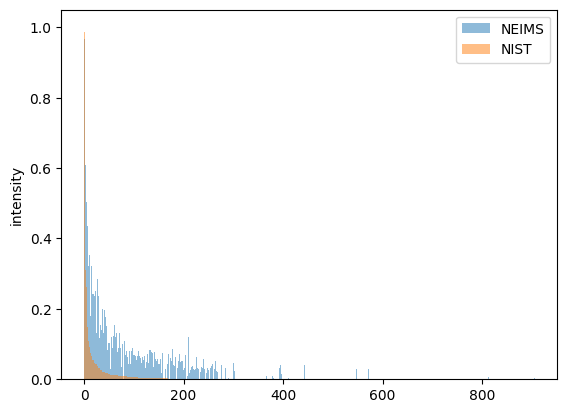

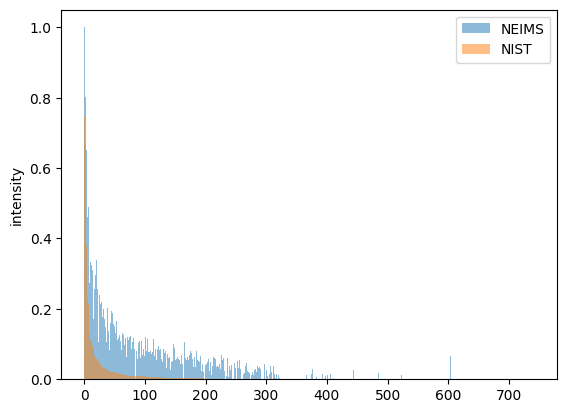

In [109]:
# take neims and nist corresponding spectra and enlong one of them to fit the other (with zeros)
# sort both according to the NIST. You can plot it I guess
def get_sorted_mzs(nist_arr, neims_arr):
    # pad the arrays
    neims_l = neims_arr.shape[0]
    nist_l = nist_arr.shape[0]
    if nist_l < neims_l:
        nist_arr = np.pad(nist_arr, (0, neims_l - nist_l))
    else: 
        neims_arr = np.pad(neims_arr, (0, nist_l - neims_l))
    zipped = list(zip(nist_arr, neims_arr))
    zipped.sort(key=lambda x : x[0], reverse=True)
    
    nist_arr = [x for x,y in zipped]
    neims_arr = [y for x,y in zipped]
    
    return nist_arr, neims_arr

for key in nist_test_spec.keys():
    nist_arr, neims_arr = get_sorted_mzs(nist_test_spec[key]["spectrum"], neims_test_spec[key]["spectrum"])
    visualize_two_spectra_1array(neims_arr, nist_arr)

## Measure the peak overlap in the n biggest peaks

In [56]:
# extract n biggest mzs according to intensities and compute the overlap
def compute_overlap(neims_spec, nist_spec, n):
    zipped_nist = sorted(list(zip(nist_spec["mz"], nist_spec["intensity"])), key=lambda x : x[1], reverse=True)
    zipped_neims = sorted(list(zip(neims_spec["mz"], neims_spec["intensity"])), key=lambda x : x[1], reverse=True)
    
    n_mzs_nist = np.array([x for x,y in zipped_nist])[:min(n, len(zipped_nist))]
    n_mzs_neims = np.array([x for x,y in zipped_neims])[:min(n, len(zipped_neims))]
    overlap_size = sum(np.isin(n_mzs_nist, n_mzs_neims))
    return overlap_size, min(n_mzs_nist.shape[0], n_mzs_neims.shape[0])

def visualize_overlap(base_data, olap_data, n, title=None):
    overlaps = [compute_overlap(olap_data[k1],base_data[k2], n) for k1, k2 in list(zip(neims_test_spec.keys(),  nist_test_spec.keys()))]
    #print(overlaps)
    olap_arr = [x for x,_ in overlaps]
    base_arr = [y for _,y in overlaps]    
    
    x_labels = neims_test_spec.keys()
    xx = range(len(x_labels))
    bar_width = 0.5
    
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 5.5, forward=True)
    
    ax.bar(xx, height=olap_arr, width=bar_width, align='center', alpha=0.5, label="neims") #blue
    rects = ax.bar(xx, height=base_arr, width=bar_width, align='center', alpha=0.5, label="nist") #orange
    ax.set_title(title)
    ax.set_xlabel('spec IDs')
    ax.set_ylabel('overlapped peaks')
    ax.set_xticks(xx)
    ax.set_xticklabels(x_labels, rotation=45)
    
    # display label above nist bars
    for i in range(len(rects)):
        ax.annotate('{}/{}'.format(olap_arr[i], base_arr[i]),
                    xy=(i, base_arr[i]),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    ax.legend(["overlapped", f"min(n, num of peaks)"])
    plt.show()
    
n = 20
# make the sets smaller - like this it doesn't make sense
# visualize_overlap(nist_test_spec, neims_test_spec, n, title=f"Number of overlapped peaks between the two sets considering up to {n} biggest") 

In [57]:
# the overlap data in text form    
for key in neims_test_spec.keys():
    overlapped, out_of = compute_overlap(neims_test_spec[key], nist_test_spec[key], 20)
    smiles = nist_test_spec[key]["smiles"]
    print(f'id: {key}, smiles: {nist_test_spec[key]["smiles"]}, overlaps: {overlapped}/{out_of}')

id: 2522, smiles: C[Si](C)(C)O, overlaps: 15/20
id: 5264, smiles: CO[Si](C)(C)C, overlaps: 16/20
id: 8704, smiles: C[Si](C)(C)N=[N+]=[N-], overlaps: 16/20
id: 8729, smiles: C[Si](C)(C)N=C=O, overlaps: 14/20
id: 8740, smiles: C[Si](C)(C)N1CC1, overlaps: 14/20
id: 9583, smiles: C[Si](C)(C)NC=O, overlaps: 18/20
id: 9686, smiles: CN(C)[Si](C)(C)C, overlaps: 15/20
id: 9818, smiles: C[Si](C)(C)OC=O, overlaps: 16/20
id: 9970, smiles: CCO[Si](C)(C)C, overlaps: 17/20
id: 10255, smiles: CON[Si](C)(C)C, overlaps: 14/20
id: 10434, smiles: C[Si](C)(C)SC, overlaps: 14/20
id: 13422, smiles: C[Si](C)(C)NCC#C, overlaps: 17/20
id: 13864, smiles: C[Si](C)(C)OCC#C, overlaps: 17/20
id: 14807, smiles: C[Si](C)(C)N1CCC1, overlaps: 15/20
id: 15324, smiles: C[Si](C)(C)OCC=C, overlaps: 14/20
id: 15843, smiles: C[Si](C)(C)N=C=S, overlaps: 13/20
id: 15844, smiles: CC(=O)N[Si](C)(C)C, overlaps: 14/20
id: 15990, smiles: CC(C)N[Si](C)(C)C, overlaps: 17/20
id: 16280, smiles: CC(=O)O[Si](C)(C)C, overlaps: 14/20
id: 16

### Visualize mean overlap rate dependent on n

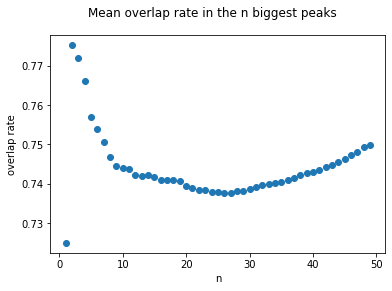

In [58]:
def visualize_mean_overlap(base_data, olap_data, n):
    means = []
    for i in range(1, n):
        overlaps = [compute_overlap(olap_data[k1],base_data[k2], i) for k1, k2 in list(zip(neims_test_spec.keys(),  nist_test_spec.keys()))]
        mean_rate = sum([x/y for x, y in overlaps])/len(overlaps)
        means.append(mean_rate)
        ##########
        #print(str(i) + ":", mean_rate)
    plt.scatter(range(1,n), means)
    plt.xlabel("n")
    plt.ylabel("overlap rate")
    plt.suptitle("Mean overlap rate in the n biggest peaks")
visualize_mean_overlap(nist_test_spec, neims_test_spec, 50)

# Explore categories of molecules

Add to the dictionary the information about categories adapted from:  https://gitlab.unige.ch/Pierre-Marie.Allard/pybatchclassyfire/-/tree/master/notebook

,smiles,inchikey,PREDICTED SPECTRUM,ID,Smiles,Molecule,nist_idMINUS1
0,C[Si](C)(C)O,AAPLIUHOKVUFCC-UHFFFAOYSA-N,14 50\n15 151\n25 12\n26 46\n27 163\n29 141\n3...,0,C[Si](C)(C)O,,2522
1,CO[Si](C)(C)C,POPACFLNWGUDSR-UHFFFAOYSA-N,14 30\n15 134\n25 1\n26 32\n27 112\n28 125\n29...,1,CO[Si](C)(C)C,,5264
2,C[Si](C)(C)N=[N+]=[N-],SEDZOYHHAIAQIW-UHFFFAOYSA-N,14 60\n15 114\n25 9\n26 67\n27 86\n28 145\n29 ...,2,C[Si](C)(C)N=[N+]=[N-],,8704
3,C[Si](C)(C)N=C=O,NIZHERJWXFHGGU-UHFFFAOYSA-N,14 49\n15 110\n18 6\n25 12\n26 79\n27 122\n28 ...,3,C[Si](C)(C)N=C=O,,8729
4,C[Si](C)(C)N1CC1,OHCNQFYTLLGNOE-UHFFFAOYSA-N,14 0\n15 55\n27 53\n28 58\n29 95\n30 29\n31 64...,4,C[Si](C)(C)N1CC1,,8740
...,...,...,...,...,...,...,...
5909,COc1ccc(-c2cc(=O)c3c(O[Si](C)(C)C)cc(OC4OC(COC...,JXOSQLBPQTZSDU-UHFFFAOYSA-N,43 1\n44 1\n55 0\n71 0\n73 516\n74 33\n75 99\n...,5909,COc1ccc(-c2cc(=O)c3c(O[Si](C)(C)C)cc(OC4OC(COC...,,350598
5910,COc1ccc(C2CC(=O)c3c(cc(OC4OC(COC5OC(C)C(O[Si](...,KGNFGWOIKRFMAR-UHFFFAOYSA-N,43 2\n44 6\n46 0\n55 1\n59 3\n73 572\n74 44\n7...,5910,COc1ccc(C2CC(=O)c3c(cc(OC4OC(COC5OC(C)C(O[Si](...,,350600
5912,CC1OC(Oc2c(-c3ccc(O[Si](C)(C)C)cc3)oc3cc(OC4OC...,CRQNENZHDPWFKZ-UHFFFAOYSA-N,41 2\n43 5\n55 0\n69 36\n71 9\n73 834\n74 38\n...,5912,CC1OC(Oc2c(-c3ccc(O[Si](C)(C)C)cc3)oc3cc(OC4OC...,,350606
5913,C[Si](C)(C)OCC1OC(Oc2cc(O[Si](C)(C)C)c3c(=O)c(...,APFIHSRYZYIEAP-UHFFFAOYSA-N,43 8\n45 21\n55 0\n57 0\n59 38\n69 25\n70 3\n7...,5913,C[Si](C)(C)OCC1OC(Oc2cc(O[Si](C)(C)C)c3c(=O)c(...,,350613

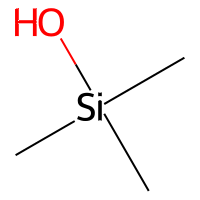
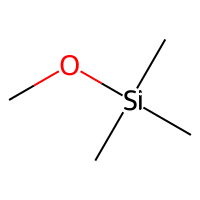
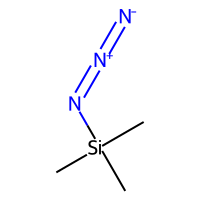
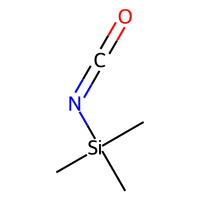
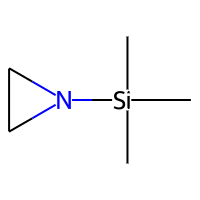
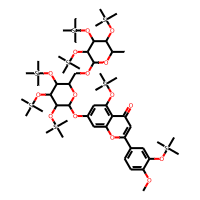
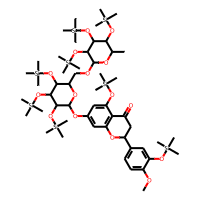
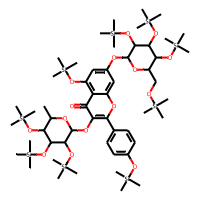
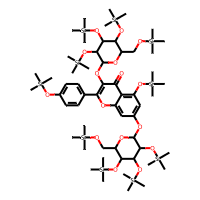
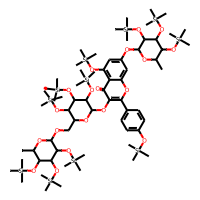

In [21]:
# neims_test.sort_values(by="nist_idMINUS1")


In [59]:
# convert neims/nist to dataframe
def convert_to_dataframe(dic):
    df = pd.DataFrame.from_dict(dic).transpose()
    return df

neims_df = convert_to_dataframe(neims_test_spec)#.sort_values(by="nist_idMINUS1")
nist_df = convert_to_dataframe(nist_test_spec)
neims_df

,smiles,mz,intensity,spectrum
2522,C[Si](C)(C)O,"[14, 15, 25, 26, 27, 29, 31, 32, 33, 40, 41, 4...","[0.05005005005005005, 0.15115115115115116, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5264,CO[Si](C)(C)C,"[14, 15, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...","[0.03003003003003003, 0.13413413413413414, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8704,C[Si](C)(C)N=[N+]=[N-],"[14, 15, 25, 26, 27, 28, 29, 30, 31, 32, 40, 4...","[0.06006006006006006, 0.11411411411411411, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8729,C[Si](C)(C)N=C=O,"[14, 15, 18, 25, 26, 27, 28, 29, 30, 31, 38, 3...","[0.04904904904904905, 0.11011011011011011, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8740,C[Si](C)(C)N1CC1,"[14, 15, 27, 28, 29, 30, 31, 39, 41, 42, 43, 4...","[0.0, 0.055055055055055056, 0.0530530530530530...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
350601,CC(C(=O)N(C1=C(C(=C(C(=C1I)C(=O)NC(CO[Si](C)(C...,"[27, 28, 29, 30, 39, 41, 42, 43, 44, 45, 49, 5...","[0.01701701701701702, 0.023023023023023025, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
350606,CC1C(C(C(C(O1)OC2=C(OC3=C(C2=O)C(=CC(=C3)OC4C(...,"[41, 43, 55, 69, 71, 73, 74, 75, 76, 83, 91, 1...","[0.002002002002002002, 0.005005005005005005, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
350613,C[Si](C)(C)OCC1C(C(C(C(O1)OC2=CC3=C(C(=C2)O[Si...,"[43, 45, 55, 57, 59, 69, 70, 71, 72, 73, 74, 7...","[0.008008008008008008, 0.021021021021021023, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
350614,C[Si](C)(C)OCC1C(C(C(C(O1)OC(C(CO[Si](C)(C)C)O...,"[28, 41, 43, 44, 45, 47, 49, 50, 53, 55, 57, 5...","[0.008008008008008008, 0.006006006006006006, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [60]:
# get file with inchikeys sorted by nistID
os.makedirs("tmp", exist_ok=True)
with open("./tmp/neims_test_inchikeys.inch", "w") as f:
    for key in sorted(nist_test_spec.keys()):
        f.write(nist_test_spec[key]["inchikey"] + "\n")


Now you copy the inchikeys to the mentioned website's text window and wait for the classed csv

In [61]:
# read classed csv
enriched_path = "tmp/classed_inchikey8500.csv"
test_classed = pd.read_csv(enriched_path, index_col=0, delimiter="\t")

test_classed

,Status,Kingdom,Superclass,Class,Subclass,Parent Level 1,Parent Level 2,Parent Level 3,Parent Level 4,Parent Level 5
InChIKey,,,,,,,,,,
VGGSQFUCUMXWEO-UHFFFAOYSA-N,Completed,Organic compounds,Hydrocarbons,Unsaturated hydrocarbons,Unsaturated aliphatic hydrocarbons,Unsaturated aliphatic hydrocarbons,,,,
OTMSDBZUPAUEDD-UHFFFAOYSA-N,Completed,Organic compounds,Hydrocarbons,Saturated hydrocarbons,Alkanes,Alkanes,,,,
BAVYZALUXZFZLV-UHFFFAOYSA-N,Completed,Organic compounds,Organic nitrogen compounds,Organonitrogen compounds,Amines,Primary amines,Monoalkylamines,,,
OAKJQQAXSVQMHS-UHFFFAOYSA-N,Completed,Inorganic compounds,Homogeneous non-metal compounds,Homogeneous other non-metal compounds,NaN,Homogeneous other non-metal compounds,,,,
AVXURJPOCDRRFD-UHFFFAOYSA-N,Completed,Inorganic compounds,Homogeneous non-metal compounds,Homogeneous other non-metal compounds,NaN,Homogeneous other non-metal compounds,,,,
...,...,...,...,...,...,...,...,...,...,...
BREBNYJPOXXELW-UHFFFAOYSA-N,Completed,Organic compounds,Benzenoids,Benzene and substituted derivatives,Phenylcarbamic acid esters,Phenylcarbamic acid esters,,,,
MGNFYQILYYYUBS-UHFFFAOYSA-N,Completed,Organic compounds,Benzenoids,Benzene and substituted derivatives,Phenylpropanes,Phenylpropanes,,,,
LHXBLOCHDJHVNH-UHFFFAOYSA-N,Completed,Organic compounds,Organohalogen compounds,Alkyl halides,Alkyl fluorides,Perfluoroalkyl carboxylic acid and derivatives,,,,


In [62]:
# add empty classes to nist_test_spec
for col in test_classed.columns:
    nist_df[col] = np.nan

In [63]:
nist_df

,name,smiles,inchikey,mz,intensity,spectrum,Status,Kingdom,Superclass,Class,Subclass,Parent Level 1,Parent Level 2,Parent Level 3,Parent Level 4,Parent Level 5
2522,"Silanol, trimethyl-",C[Si](C)(C)O,AAPLIUHOKVUFCC-UHFFFAOYSA-N,"[15, 28, 29, 30, 31, 41, 42, 43, 44, 45, 46, 4...","[0.068008008008008, 0.03600600600600601, 0.026...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5264,"Methanol, TMS derivative",CO[Si](C)(C)C,POPACFLNWGUDSR-UHFFFAOYSA-N,"[15, 27, 28, 29, 30, 31, 32, 39, 41, 42, 43, 4...","[0.012002002002002002, 0.003003003003003003, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8704,Azidotrimethylsilane,C[Si](C)(C)N=[N+]=[N-],SEDZOYHHAIAQIW-UHFFFAOYSA-N,"[14, 15, 26, 27, 28, 29, 30, 31, 32, 33, 39, 4...","[0.001001001001001001, 0.007997997997997998, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8729,"Silane, isocyanatotrimethyl-",C[Si](C)(C)N=C=O,NIZHERJWXFHGGU-UHFFFAOYSA-N,"[15, 26, 27, 28, 29, 30, 31, 40, 41, 42, 43, 4...","[0.004004004004004004, 0.001001001001001001, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8740,"Aziridine, TMS derivative",C[Si](C)(C)N1CC1,OHCNQFYTLLGNOE-UHFFFAOYSA-N,"[29, 30, 41, 43, 44, 45, 46, 56, 59, 60, 72, 7...","[0.05, 0.01, 0.015005005005005005, 0.130010010...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350601,"(S)-N,N'-Bis-[2-trimethylsilyloxy-1-(trimethyl...",CC(C(=O)N(C1=C(C(=C(C(=C1I)C(=O)NC(CO[Si](C)(C...,WGWXQBYILABNFZ-DEOSSOPVSA-N,"[42, 43, 44, 50, 51, 52, 53, 60, 73, 74, 75, 7...","[0.017997997997998, 0.007997997997997998, 0.04...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350606,"Kaempferol-3-O-rhamnoside-7-O-glucoside, tms-",CC1C(C(C(C(O1)OC2=C(OC3=C(C2=O)C(=CC(=C3)OC4C(...,CRQNENZHDPWFKZ-UHFFFAOYSA-N,"[73, 147, 204, 217, 273, 361, 362, 415, 430, 4...","[1.0, 0.22002002002002002, 0.18002002002002002...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350613,"Kaempferol-3,7-O-diglucoside, tms-",C[Si](C)(C)OCC1C(C(C(C(O1)OC2=CC3=C(C(=C2)O[Si...,APFIHSRYZYIEAP-UHFFFAOYSA-N,"[73, 147, 204, 217, 361, 415, 430, 450, 487, 5...","[1.0, 0.7300700700700701, 0.21002002002002002,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350614,Per-O-trimethylsilyl-(3-O-.alpha.-d-mannopyran...,C[Si](C)(C)OCC1C(C(C(C(O1)OC(C(CO[Si](C)(C)C)O...,AGCGTUNOUDOTHI-KRYNHHJKSA-N,"[43, 44, 45, 55, 56, 57, 59, 67, 69, 70, 71, 7...","[0.07900900900900902, 0.033003003003003004, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
%%time
# fill given info to the table
def enrich_with_classes(ds_orig):
    counter = 0
    ds = ds_orig.copy()
    for index, row in ds.iterrows():
#         print(row)
        inchi_ds = row["inchikey"]
        if inchi_ds not in test_classed.index:
            continue
            
        for name, val in test_classed.loc[inchi_ds].items():            
            ds.loc[index, name] = val
    print(counter)
    return ds

nist_df_classed = enrich_with_classes(nist_df)

0
CPU times: user 890 ms, sys: 4.36 ms, total: 894 ms
Wall time: 880 ms


In [65]:
neims_df

,smiles,mz,intensity,spectrum
2522,C[Si](C)(C)O,"[14, 15, 25, 26, 27, 29, 31, 32, 33, 40, 41, 4...","[0.05005005005005005, 0.15115115115115116, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5264,CO[Si](C)(C)C,"[14, 15, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...","[0.03003003003003003, 0.13413413413413414, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8704,C[Si](C)(C)N=[N+]=[N-],"[14, 15, 25, 26, 27, 28, 29, 30, 31, 32, 40, 4...","[0.06006006006006006, 0.11411411411411411, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8729,C[Si](C)(C)N=C=O,"[14, 15, 18, 25, 26, 27, 28, 29, 30, 31, 38, 3...","[0.04904904904904905, 0.11011011011011011, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8740,C[Si](C)(C)N1CC1,"[14, 15, 27, 28, 29, 30, 31, 39, 41, 42, 43, 4...","[0.0, 0.055055055055055056, 0.0530530530530530...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
350601,CC(C(=O)N(C1=C(C(=C(C(=C1I)C(=O)NC(CO[Si](C)(C...,"[27, 28, 29, 30, 39, 41, 42, 43, 44, 45, 49, 5...","[0.01701701701701702, 0.023023023023023025, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
350606,CC1C(C(C(C(O1)OC2=C(OC3=C(C2=O)C(=CC(=C3)OC4C(...,"[41, 43, 55, 69, 71, 73, 74, 75, 76, 83, 91, 1...","[0.002002002002002002, 0.005005005005005005, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
350613,C[Si](C)(C)OCC1C(C(C(C(O1)OC2=CC3=C(C(=C2)O[Si...,"[43, 45, 55, 57, 59, 69, 70, 71, 72, 73, 74, 7...","[0.008008008008008008, 0.021021021021021023, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
350614,C[Si](C)(C)OCC1C(C(C(C(O1)OC(C(CO[Si](C)(C)C)O...,"[28, 41, 43, 44, 45, 47, 49, 50, 53, 55, 57, 5...","[0.008008008008008008, 0.006006006006006006, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [66]:
from matchms import Spectrum
from matchms.similarity import CosineGreedy

# udelej vsechny podobnosti, dej je do Series a tu pak pridej je do NIST_DF
def assign_similarities():
    simils = []
    weighted_simils = []
    matchs = []

    for i in nist_df_classed.index:    
        reference = Spectrum(mz=nist_df_classed.loc[i,"mz"].astype(float),
                             intensities=nist_df_classed.loc[i,"intensity"])
        query = Spectrum(mz=neims_df.loc[i,"mz"].astype(float),
                         intensities=neims_df.loc[i,"intensity"])

        # Use factory to construct a similarity function
        cosine_simil = CosineGreedy(tolerance=0.2, mz_power=0)
        score = cosine_simil.pair(reference, query)
        weighted_cosine_simil = CosineGreedy(tolerance=0.2, mz_power=1)
        w_score = weighted_cosine_simil.pair(reference, query)


#         print(round(score['score'].item)
        simils.append(np.around(score['score'], 2))
        weighted_simils.append(np.around(w_score['score'], 2))
        matchs.append(score['matches'])

    assert len(simils) == len(nist_df_classed) and len(matchs) == len(nist_df_classed)
    nist_df_classed["simil_to_neims"] = simils
    nist_df_classed["weighted_simil_to_neims"] = weighted_simils
    nist_df_classed["matched_peaks_neims"] = matchs
    
assign_similarities()    


In [67]:
# add rate of matched peaks
rate = [round(nist_df_classed.loc[i,"matched_peaks_neims"]/len(nist_df_classed.loc[i,"mz"]), 2) for i in nist_df_classed.index]
nist_df_classed["matched_rate"] = rate

In [68]:
# nist_df_classed.loc[nist_df_classed["Class"].notna()]
nist_df_classed

,name,smiles,inchikey,mz,intensity,spectrum,Status,Kingdom,Superclass,Class,Subclass,Parent Level 1,Parent Level 2,Parent Level 3,Parent Level 4,Parent Level 5,simil_to_neims,weighted_simil_to_neims,matched_peaks_neims,matched_rate
2522,"Silanol, trimethyl-",C[Si](C)(C)O,AAPLIUHOKVUFCC-UHFFFAOYSA-N,"[15, 28, 29, 30, 31, 41, 42, 43, 44, 45, 46, 4...","[0.068008008008008, 0.03600600600600601, 0.026...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Completed,Organic compounds,Organometallic compounds,Organometalloid compounds,Organosilicon compounds,Organoheterosilanes,Trialkylheterosilanes,,,,0.68,0.71,33,0.72
5264,"Methanol, TMS derivative",CO[Si](C)(C)C,POPACFLNWGUDSR-UHFFFAOYSA-N,"[15, 27, 28, 29, 30, 31, 32, 39, 41, 42, 43, 4...","[0.012002002002002002, 0.003003003003003003, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.77,0.79,35,0.90
8704,Azidotrimethylsilane,C[Si](C)(C)N=[N+]=[N-],SEDZOYHHAIAQIW-UHFFFAOYSA-N,"[14, 15, 26, 27, 28, 29, 30, 31, 32, 33, 39, 4...","[0.001001001001001001, 0.007997997997997998, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Completed,Organic compounds,Organometallic compounds,Organometalloid compounds,Organosilicon compounds,Organoheterosilanes,Trialkylheterosilanes,,,,0.82,0.86,35,0.69
8729,"Silane, isocyanatotrimethyl-",C[Si](C)(C)N=C=O,NIZHERJWXFHGGU-UHFFFAOYSA-N,"[15, 26, 27, 28, 29, 30, 31, 40, 41, 42, 43, 4...","[0.004004004004004004, 0.001001001001001001, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Completed,Organic compounds,Organometallic compounds,Organometalloid compounds,Organosilicon compounds,Organoheterosilanes,Trialkylheterosilanes,,,,0.68,0.78,36,0.88
8740,"Aziridine, TMS derivative",C[Si](C)(C)N1CC1,OHCNQFYTLLGNOE-UHFFFAOYSA-N,"[29, 30, 41, 43, 44, 45, 46, 56, 59, 60, 72, 7...","[0.05, 0.01, 0.015005005005005005, 0.130010010...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.85,0.83,23,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350601,"(S)-N,N'-Bis-[2-trimethylsilyloxy-1-(trimethyl...",CC(C(=O)N(C1=C(C(=C(C(=C1I)C(=O)NC(CO[Si](C)(C...,WGWXQBYILABNFZ-DEOSSOPVSA-N,"[42, 43, 44, 50, 51, 52, 53, 60, 73, 74, 75, 7...","[0.017997997997998, 0.007997997997997998, 0.04...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.37,0.13,31,0.51
350606,"Kaempferol-3-O-rhamnoside-7-O-glucoside, tms-",CC1C(C(C(C(O1)OC2=C(OC3=C(C2=O)C(=CC(=C3)OC4C(...,CRQNENZHDPWFKZ-UHFFFAOYSA-N,"[73, 147, 204, 217, 273, 361, 362, 415, 430, 4...","[1.0, 0.22002002002002002, 0.18002002002002002...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.60,0.24,8,0.44
350613,"Kaempferol-3,7-O-diglucoside, tms-",C[Si](C)(C)OCC1C(C(C(C(O1)OC2=CC3=C(C(=C2)O[Si...,APFIHSRYZYIEAP-UHFFFAOYSA-N,"[73, 147, 204, 217, 361, 415, 430, 450, 487, 5...","[1.0, 0.7300700700700701, 0.21002002002002002,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.70,0.30,7,0.50
350614,Per-O-trimethylsilyl-(3-O-.alpha.-d-mannopyran...,C[Si](C)(C)OCC1C(C(C(C(O1)OC(C(CO[Si](C)(C)C)O...,AGCGTUNOUDOTHI-KRYNHHJKSA-N,"[43, 44, 45, 55, 56, 57, 59, 67, 69, 70, 71, 7...","[0.07900900900900902, 0.033003003003003004, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.88,0.88,93,0.85


In [69]:
nist_df_classed.describe()

,simil_to_neims,weighted_simil_to_neims,matched_rate
count,5916.000000,5916.000000,5916.000000
mean,0.801765,0.814388,0.851395
std,0.080820,0.104858,0.120517
min,0.050000,0.040000,0.040000
25%,0.770000,0.780000,0.790000
50%,0.820000,0.840000,0.880000
75%,0.850000,0.880000,0.940000
max,0.960000,0.980000,1.000000


### Class Stats

In [34]:
# stat: pocty hodnot jednotlivych sloupcu
for inspected_col in ["Kingdom", "Superclass", "Class", "Subclass"]:
    print(f"\t{inspected_col}:")
    print(nist_df_classed[inspected_col].value_counts())

# => smysl dava asi operovat na Superclass

	Kingdom:
Organic compounds    177
Name: Kingdom, dtype: int64
	Superclass:
Organometallic compounds           80
Benzenoids                         55
Organic acids and derivatives      17
Organoheterocyclic compounds       14
Lipids and lipid-like molecules     7
Organic oxygen compounds            4
Name: Superclass, dtype: int64
	Class:
Organometalloid compounds                   80
Benzene and substituted derivatives         44
Carboxylic acids and derivatives            15
Phenol ethers                               10
Prenol lipids                                5
Diazines                                     4
Organooxygen compounds                       4
Pyridines and derivatives                    2
Fatty Acyls                                  2
Keto acids and derivatives                   1
Pyrrolidines                                 1
Oxazinanes                                   1
Benzodioxoles                                1
Naphthalenes                                 1

In [35]:
inspected_col = "Superclass"
# nist classed-only
nist_co = nist_df_classed.loc[nist_df_classed[inspected_col].notna()].copy()

In [36]:
# stat: prumerna podobnost u Superclass i se zminkou o poctu vzorku
stats = []
for cat in sorted(nist_co["Superclass"].unique()):
    cat_slice = nist_co.loc[nist_co["Superclass"] == cat]
    avg_simils = sum(cat_slice["simil_to_neims"])/len(cat_slice)
    avg_w_simils = sum(cat_slice["weighted_simil_to_neims"])/len(cat_slice)
    avg_matched_peaks = sum(cat_slice["matched_peaks_neims"])/len(cat_slice)
    avg_matched_rate = sum(cat_slice["matched_rate"])/len(cat_slice)
    avg_spec_len = sum([len(nist_df_classed.loc[i,"mz"]) for i in cat_slice.index])/len(cat_slice)
    stats.append([len(cat_slice), round(avg_simils, 2), round(avg_w_simils, 2), round(avg_spec_len,2), round(avg_matched_peaks,2), round(avg_matched_rate,2)])
    #print(f'{cat}: {avg_simils}')

In [37]:
stats_df = pd.DataFrame(stats, index=sorted(nist_co["Superclass"].unique()), columns=["count", "avg_simil", "avg_w_simil", "avg_spec_len", "avg_matched_peaks", "avg_matched_rate"])
stats_df

,count,avg_simil,avg_w_simil,avg_spec_len,avg_matched_peaks,avg_matched_rate
Benzenoids,55,0.80,0.85,113.67,93.16,0.83
Lipids and lipid-like molecules,7,0.81,0.81,109.43,88.43,0.82
Organic acids and derivatives,17,0.78,0.73,93.06,66.00,0.73
Organic oxygen compounds,4,0.75,0.82,107.75,94.25,0.88
Organoheterocyclic compounds,14,0.74,0.78,121.00,97.21,0.82
Organometallic compounds,80,0.78,0.79,84.50,64.90,0.79


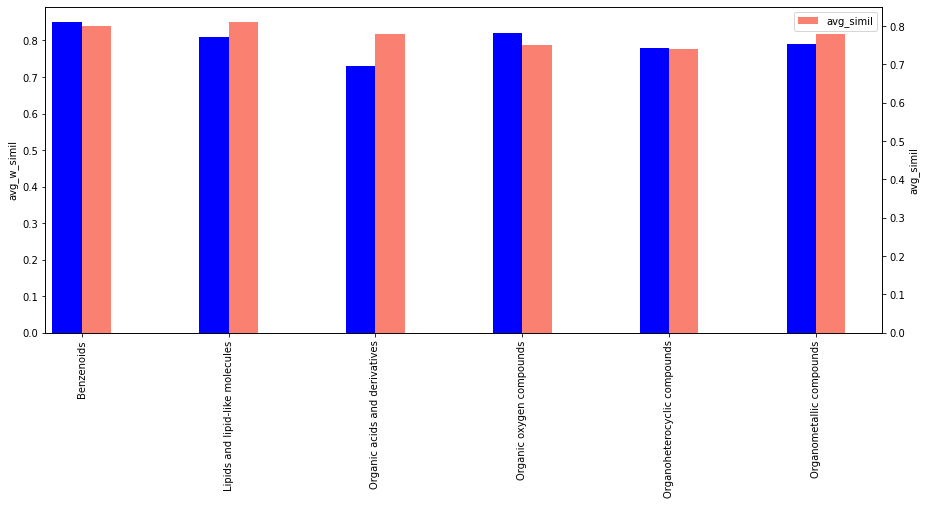

In [38]:
# Create some mock data
cat1 = "avg_w_simil" # "count"
cat2 = "avg_simil"

def visualize_two_cats(cat1, cat2):
    fig = plt.figure() # Create matplotlib figure

    ax = fig.add_subplot(111) # Create matplotlib axes
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

    width = 0.2
    stats_df[cat1].plot(kind='bar', color='blue', ax=ax, position=1, figsize=(15,6), width=width)
    stats_df[cat2].plot(kind='bar', color='salmon', ax=ax2, position=0, figsize=(15,6), width=width, legend=cat2)

    ax.set_ylabel(cat1)
    ax2.set_ylabel(cat2)
#     plt.legend(cat1,cat2)
    plt.show()
    
visualize_two_cats(cat1, cat2)

===================================================================================================================================================================

# HW Vizualizace

In [ ]:
nist_df_one_arr

In [ ]:
# chceme: obe spektra v jednom reprezentovany jako list 
    # + smiles, inchikey, simil, w. simil, superclass (naslende dropni co nemaji), molecule (z neims_test), name(z nist_test_spec)
# create nist and neims spectra that do not have mz, only 0 on positions that have zero
def put_spectra_to_one_array(data):
    spectra = []
    for index, row in data.iterrows():
#         print(spec)
        mzs = row["mz"]
        ints = row["intensity"]
        max_ = max(mzs)
        new_spec = np.zeros(max_+1)
        for i in range(len(mzs)):
            new_spec[mzs[i]] = ints[i]
        spectra.append(new_spec)
        if spectra == []:
            print(spectra)
    print(len(spectra))
    data["spectrum"] = spectra
    return data

# toto by se mozna hodilo dat vys rovnou -_o_-

neims_df_one_arr = put_spectra_to_one_array(neims_df)
nist_df_one_arr = put_spectra_to_one_array(nist_df_classed)    


In [ ]:
vizu_df

In [ ]:
vizu_df = nist_df_one_arr[["name", "smiles", "inchikey", "Superclass", "simil_to_neims", "weighted_simil_to_neims", "matched_peaks_neims", "matched_rate", "spectrum"]]
vizu_df.rename(columns={"spectrum": "nist_spec", "Superclass": "superclass", "simil_to_neims": "simil", "weighted_simil_to_neims": "w_simil", "matched_peaks_neims": "matched_peaks_neims"}, inplace=True)
vizu_df = vizu_df.assign(neims_spec = neims_df_one_arr["spectrum"].tolist())
vizu_df = vizu_df.assign(molecule = neims_test.sort_values(by="nist_idMINUS1")["Molecule"].tolist())
vizu_df = vizu_df[vizu_df.nist_spec.apply(lambda x: len(x)<300)] # filtering according to len

# vizu_df["molecule"] = list(neims_test["Molecule"])

In [ ]:
vizu_df

In [ ]:
!ls

In [ ]:
vizu_df.to_csv("vizu_data.csv")

In [ ]:
a=4